In [1]:
# comparing how two models do against my FGSM attack 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

momentsnotice           Mon Dec 21 20:59:39 2020  418.152.00
[0] GeForce GTX 1080 Ti | 72'C,   0 % |  6797 / 11178 MB | salami(6787M)
[1] GeForce GTX 1080 Ti | 90'C,  96 % |  7819 / 11178 MB | salami(7809M)


In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
# torch.cuda.set_device(1)

CUDA Available:  False
Using device: cpu


In [8]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [9]:
# load MNIST data
batch_size = 10000
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size)
# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000

In [11]:
# load classic model
classic_model_path = "../Experiments/sample_models/sample_classic_full.pth"
classic_model = torch.load(classic_model_path, map_location=torch.device(device))
# classic_model.to(device)

In [13]:
# classic model params
!cat '../Experiments/sample_models/sample_classic_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [14]:
# test the model
classic_model.eval()

# loss func
cross_ent_loss = fgnh.def_classical_cross_ent_loss()

_ = fgnh.test(classic_model, mnist_train_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(classic_model, mnist_val_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0318, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0932, Accuracy: 9739/10000 (97%)


In [12]:
# load fgn model
fgn_model_path = '../Experiments/sample_models/sample_FGN_full.pth'
fgn_model = torch.load(fgn_model_path, map_location=torch.device(device))

# # recreate the fgn model
# # dict load
# hidden_layer_sizes = [32,32]
# drop_p = 0.2
# covar_type = 'diag'
# ordinal = float(5.)
# non_lin =  torch.tanh

# fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
#                                      covar_type=covar_type, ordinal=ordinal, non_lin=non_lin)


# # model.load_state_dict(state_dict=torch.load(dict_path))

# # load weights
# fgn_model.load_state_dict(torch.load("../Experiments/sample_models/sample_fgn_state_dict.pth"))

# # or convert
# fgnl.convert_classic_to_fgn(classic_model, fgn_model)


# fgn_model.to(device)

In [15]:
# classic model params
!cat '../Experiments/sample_models/sample_FGN_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
ordinal 2.0
covar_type sphere
lambda for l2 loss 8e-06
lambda for sigma loss 1e-06
non-linearity True


In [16]:
# convert model ?
fgnl.convert_classic_to_fgn(classic_model, fgn_model, init_factor=1e1, verbose=True)

odict_keys([])

Classic odict_keys(['hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weight', 'hidden_layers.4.bias', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_layers.5.running_mean', 'hidden_layers.5.running_var', 'hidden_layers.5.num_batches_tracked', 'ib.weight', 'ib.bias', 'ib.running_mean', 'ib.running_var', 'ib.num_batches_tracked', 'fl.weight', 'fl.bias'])
FGN odict_keys(['hidden_layers.1.weights', 'hidden_layers.1.biases', 'hidden_layers.1.centers', 'hidden_layers.1.inv_covars', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weights', 'hidden_layers.4.biases', 'hidden_layers.4.centers', 'hidden_layers.4.inv_covars', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_la

In [17]:
# test the model
fgn_model.eval()
# # switch to random eval
# try:
#     fgn_model.set_random_eval(True)
# except: 
#     pass

# loss func
cross_ent_loss = fgnh.def_classical_cross_ent_loss()

_ = fgnh.test(fgn_model, mnist_train_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, mnist_val_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0320, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0922, Accuracy: 9738/10000 (97%)


# Untargeted Attacks

In [103]:
# parameters of the experiment
attack_params = {'targeted':False,
                 'confidence_req':0.5,
                 'loss_func':torch.nn.CrossEntropyLoss(), 
                 'data_classes':list(range(10)), 
                 'data_bounds':(min_pix, max_pix),
                 'steps': 5,
                 'max_noise':(max_pix-min_pix)*10/128,
                 'step_size':(max_pix-min_pix)/64,}

# from EXPLAINING AND HARNESSING ADVERSARIAL EXAMPLES
# "Here our of .007 corresponds to the magnitude of the smallest bit of an 8 bit image encoding after GoogLeNet’s conversion to real numbers.
# so equivalent step size is: +-1 to the value of a pixel
# <=>(max_pix-min_pix)/128.0 and 
# only one step taken, so max_noise wont actually clip anything

for k in attack_params.keys():
    print(k, attack_params[k])

dataloader = mnist_val_loader
num_attacks = 3*len(mnist_val_loader.dataset.tensors[0])
# num_attacks = 10
verbose = False

targeted False
confidence_req 0.5
loss_func CrossEntropyLoss()
data_classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
data_bounds (-0.4242129623889923, 2.821486711502075)
steps 5
max_noise 0.25357028702273965
step_size 0.05071405740454793


In [17]:
# attack the classic net
classic_untargeted_attack_results = fgnl.full_FGSM_attack(classic_model, dataloader, num_attacks=num_attacks, 
                                                          attack_params=attack_params, verbose=verbose)

In [18]:
# extract lists
classic_untargeted_confidences = classic_untargeted_attack_results['confidences_list']
classic_untargeted_steps = classic_untargeted_attack_results['steps_list']
classic_untargeted_adv_classes = classic_untargeted_attack_results['adv_classes_list']
classic_untargeted_successes = classic_untargeted_attack_results['successes_list']

# indexes of sucessful attacks any %
classic_untargeted_successes_indices_any = np.flatnonzero(classic_untargeted_successes)
# above req
classic_untargeted_successes_indices_req = [i
                                            for i,v in enumerate(classic_untargeted_successes)
                                            if v and classic_untargeted_confidences[i]>=attack_params['confidence_req']]

In [ ]:
# attack the fgn net
fgn_untargeted_attack_results = fgnl.full_FGSM_attack(fgn_model, dataloader, num_attacks=num_attacks,
                                                      attack_params=attack_params, verbose=verbose)

In [ ]:
# extract lists
fgn_untargeted_confidences = fgn_untargeted_attack_results['confidences_list']
fgn_untargeted_steps = fgn_untargeted_attack_results['steps_list']
fgn_untargeted_adv_classes = fgn_untargeted_attack_results['adv_classes_list']
fgn_untargeted_successes = fgn_untargeted_attack_results['successes_list']

# indexes of sucessful attacks any %
fgn_untargeted_successes_indices_any = np.flatnonzero(fgn_untargeted_successes)
# above req
fgn_untargeted_successes_indices_req = [i 
                                        for i,v in enumerate(fgn_untargeted_successes) 
                                        if v and fgn_untargeted_confidences[i]>=attack_params['confidence_req']]

In [ ]:
### results

In [41]:
# success rates

print('Success rates with any confidence')
print("Untargeted attack on classic net success rate: {}/{}, {}%".format(len(classic_untargeted_successes_indices_any),
                                                                         num_attacks,
                                                                         len(classic_untargeted_successes_indices_any)/num_attacks))
print("Untargeted attack on classic net success rate: {}/{}, {}%".format(len(fgn_untargeted_successes_indices_any),
                                                                         num_attacks,
                                                                         len(fgn_untargeted_successes_indices_any)/num_attacks))


Success rates with any confidence
Untargeted attack on classic net success rate: 9972/30000, 0.3324%
Untargeted attack on classic net success rate: 9999/30000, 0.3333%


In [42]:
# success rates above confidence

print('Success rates with confidence >= {}'.format(attack_params['confidence_req']))
print("Untargeted attack on classic net success rate: {}/{}, {}%".format(len(classic_untargeted_successes_indices_req),
                                                                         num_attacks,
                                                                         len(classic_untargeted_successes_indices_req)/num_attacks))
print("Untargeted attack on FGN net success rate: {}/{}, {}%".format(len(fgn_untargeted_successes_indices_req),
                                                                         num_attacks,
                                                                         len(fgn_untargeted_successes_indices_req)/num_attacks))


Success rates with confidence >= 0.5
Untargeted attack on classic net success rate: 9919/30000, 0.33063333333333333%
Untargeted attack on classic net success rate: 9431/30000, 0.3143666666666667%


In [54]:
# plot params
# always plot classic first!
labels = ['classic', 'fgn']

<IPython.core.display.Javascript object>


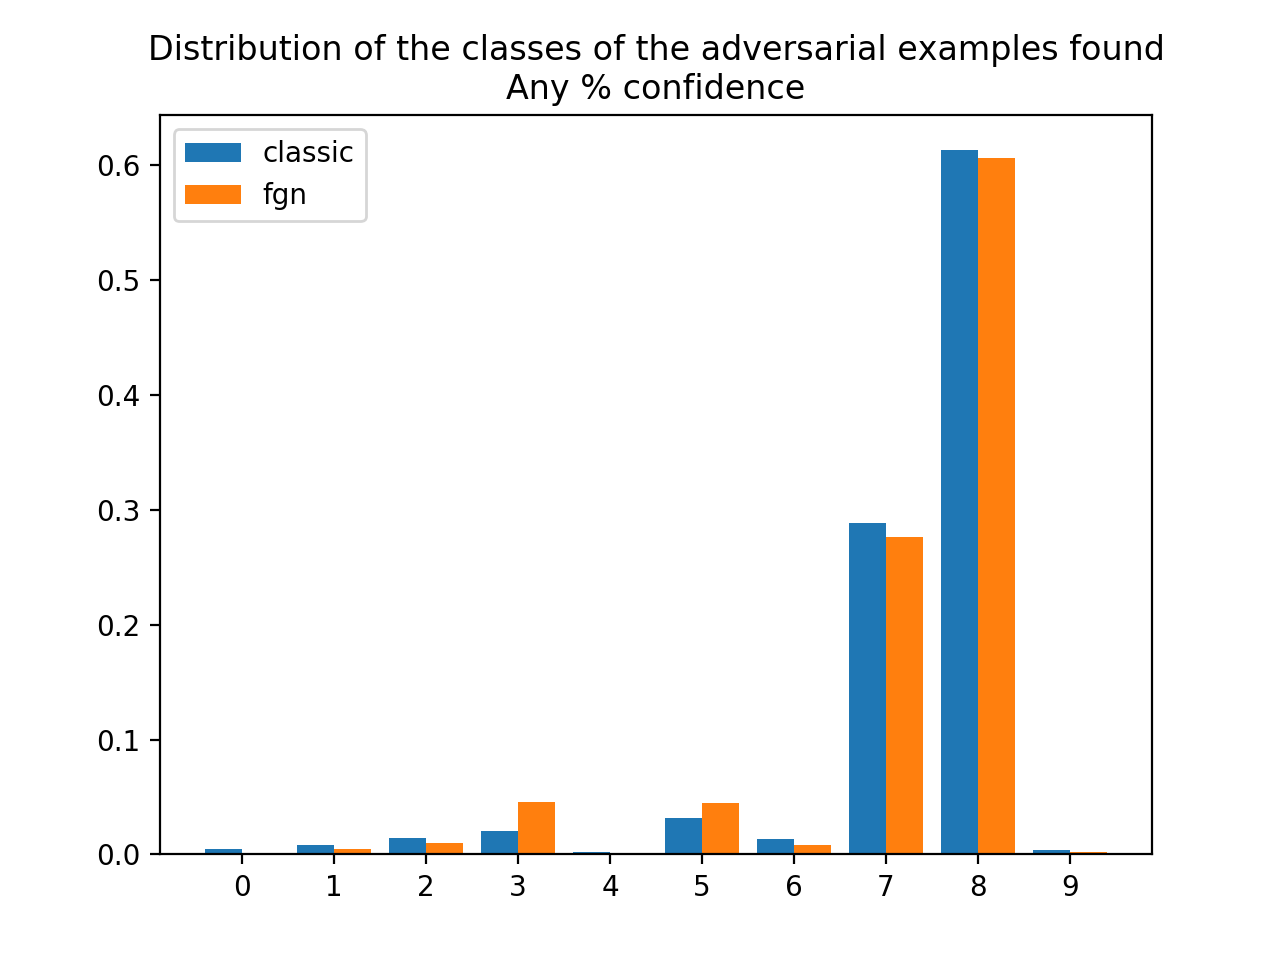

In [43]:
# adversarial class distribution
# plt.hist(classic_untargeted_adv_classes, bins=range(11), align='left', rwidth=0.9, alpha=0.5, label='classic')
# plt.hist(fgn_untargeted_adv_classes, bins=range(11), align='left', rwidth=0.8, alpha=0.5, label='fgn')

# plot 
tp1 = [classic_untargeted_adv_classes[i] for i in classic_untargeted_successes_indices_any]
tp2 = [fgn_untargeted_adv_classes[i] for i in fgn_untargeted_successes_indices_any]

to_plot = [tp1, tp2]
plt.hist(to_plot, bins=range(11), density=True, align='left', rwidth=0.8, alpha=1.0, label=labels)

plt.title("Distribution of the classes of the adversarial examples found\nAny % confidence") 
plt.xticks(range(10))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


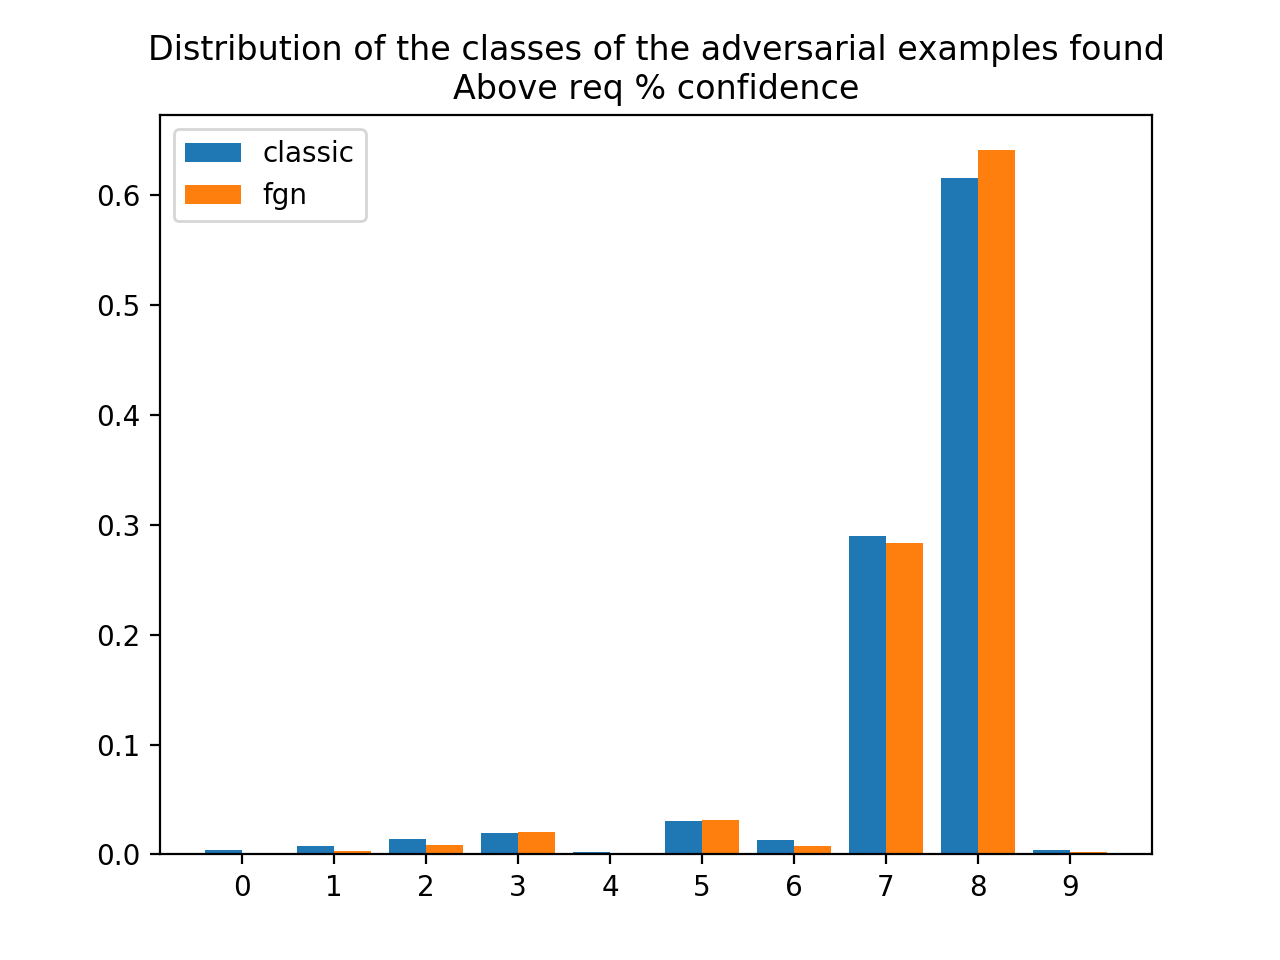

In [44]:
# adversarial class distribution
# plt.hist(classic_untargeted_adv_classes, bins=range(11), align='left', rwidth=0.9, alpha=0.5, label='classic')
# plt.hist(fgn_untargeted_adv_classes, bins=range(11), align='left', rwidth=0.8, alpha=0.5, label='fgn')

# plot 
tp1 = [classic_untargeted_adv_classes[i] for i in classic_untargeted_successes_indices_req]
tp2 = [fgn_untargeted_adv_classes[i] for i in fgn_untargeted_successes_indices_req]

to_plot = [tp1, tp2]
plt.hist(to_plot, bins=range(11), density=True, align='left', rwidth=0.8, alpha=1.0, label=labels)

plt.title("Distribution of the classes of the adversarial examples found\nAbove req % confidence") 
plt.xticks(range(10))
plt.legend()
plt.show()

With -1s
classic confidence stats:
 DescribeResult(nobs=10000, minmax=(-1.0, 0.9998693466186523), mean=0.882157627248764, variance=0.03276364879535992, skewness=-3.710296338940903, kurtosis=31.087412947954064)
fgn confidence stats:
 DescribeResult(nobs=10000, minmax=(-1.0, 0.9983377456665039), mean=0.8144903359934688, variance=0.04211866182829852, skewness=-1.0284124100522603, kurtosis=0.564344382735007)

Without -1
classic confidence stats:
 DescribeResult(nobs=9972, minmax=(0.24644288, 0.99986935), mean=0.88744247, variance=0.022879826, skewness=-1.0702728033065796, kurtosis=-0.087868829879584)
fgn confidence stats:
 DescribeResult(nobs=9999, minmax=(0.16361624, 0.99833775), mean=0.8146718, variance=0.04179354, skewness=-0.973266065120697, kurtosis=0.003059437322088243)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


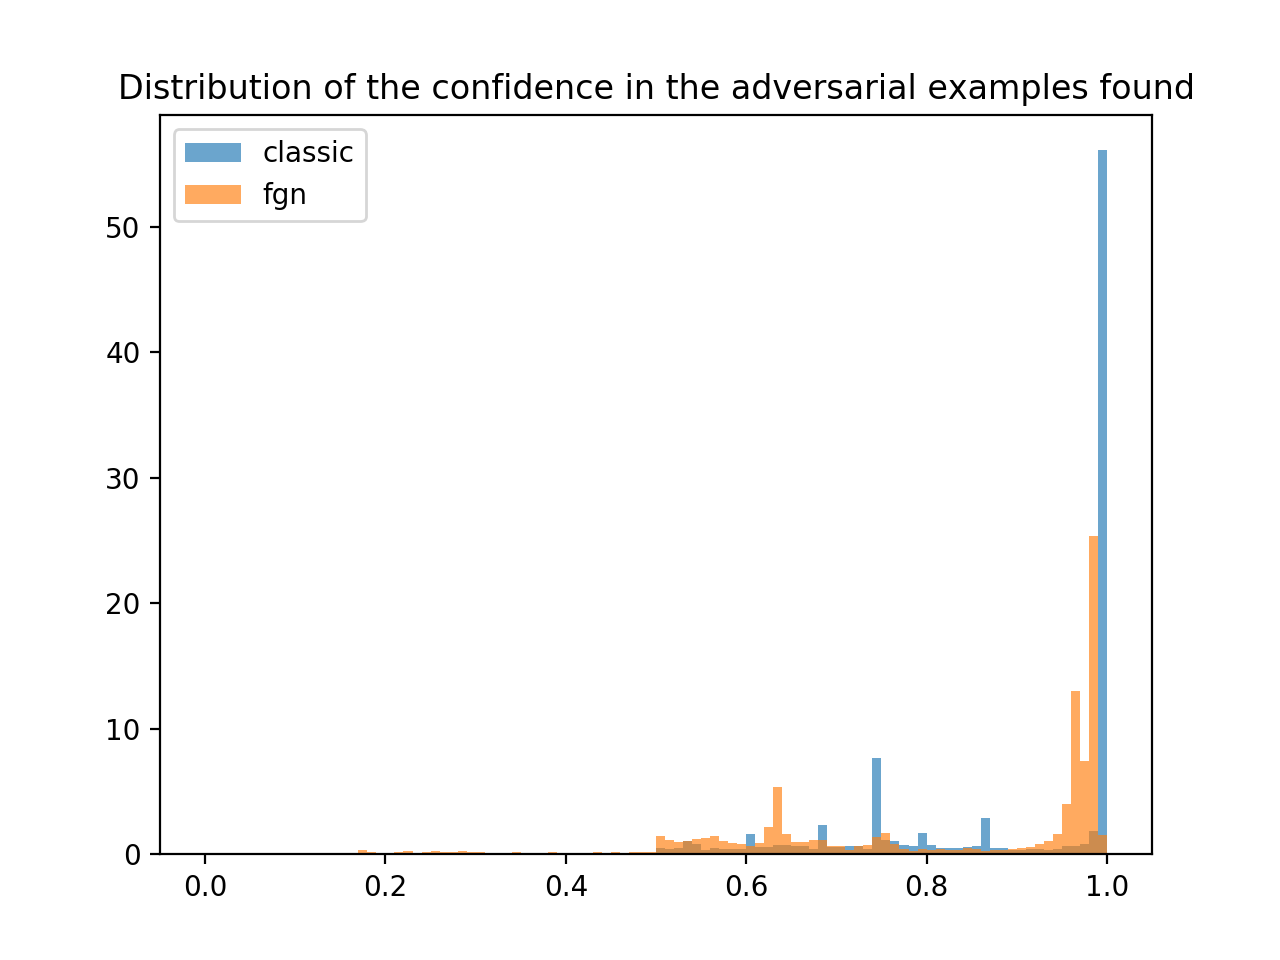

In [138]:
# plot confidence distribution
# classic_untargeted_successes_confidences = [classic_untargeted_confidences[i] 
#                                             for i in classic_untargeted_successes_indices_any]

# fgn_untargeted_successes_confidences = [fgn_untargeted_confidences[i] 
#                                             for i in fgn_untargeted_successes_indices_any]

print("With -1s")
print("classic confidence stats:\n", stats.describe(classic_untargeted_confidences))
print("fgn confidence stats:\n", stats.describe(fgn_untargeted_confidences))

print()
classic_untargeted_confidences_filtered = list(filter(lambda x:x>=0, classic_untargeted_confidences))
fgn_untargeted_confidences_filtered = list(filter(lambda x:x>=0, fgn_untargeted_confidences))


print("Without -1")
print("classic confidence stats:\n", stats.describe(classic_untargeted_confidences_filtered))
print("fgn confidence stats:\n", stats.describe(fgn_untargeted_confidences_filtered))

plt.hist(classic_untargeted_confidences, density=True, bins=[x/100 for x in range(101)], alpha=0.66, label='classic')
plt.hist(fgn_untargeted_confidences, density=True, bins=[x/100 for x in range(101)], alpha=0.66, label='fgn')

# to_plot = [striped_classic_confidence, striped_fgn_confidence]
# plt.hist(to_plot, bins=101, alpha=1.0, label=labels)

plt.title("Distribution of the confidence in the adversarial examples found") 
plt.legend()
plt.show()

Classic steps stats:
 DescribeResult(nobs=10000, minmax=(1, 5), mean=1.2023, variance=0.440818791879188, skewness=3.9582347185162017, kurtosis=16.528711759939164)
FGN steps stats:
 DescribeResult(nobs=10000, minmax=(1, 5), mean=1.405, variance=1.1754925492549253, skewness=2.671226703743872, kurtosis=5.682297808769864)


<IPython.core.display.Javascript object>


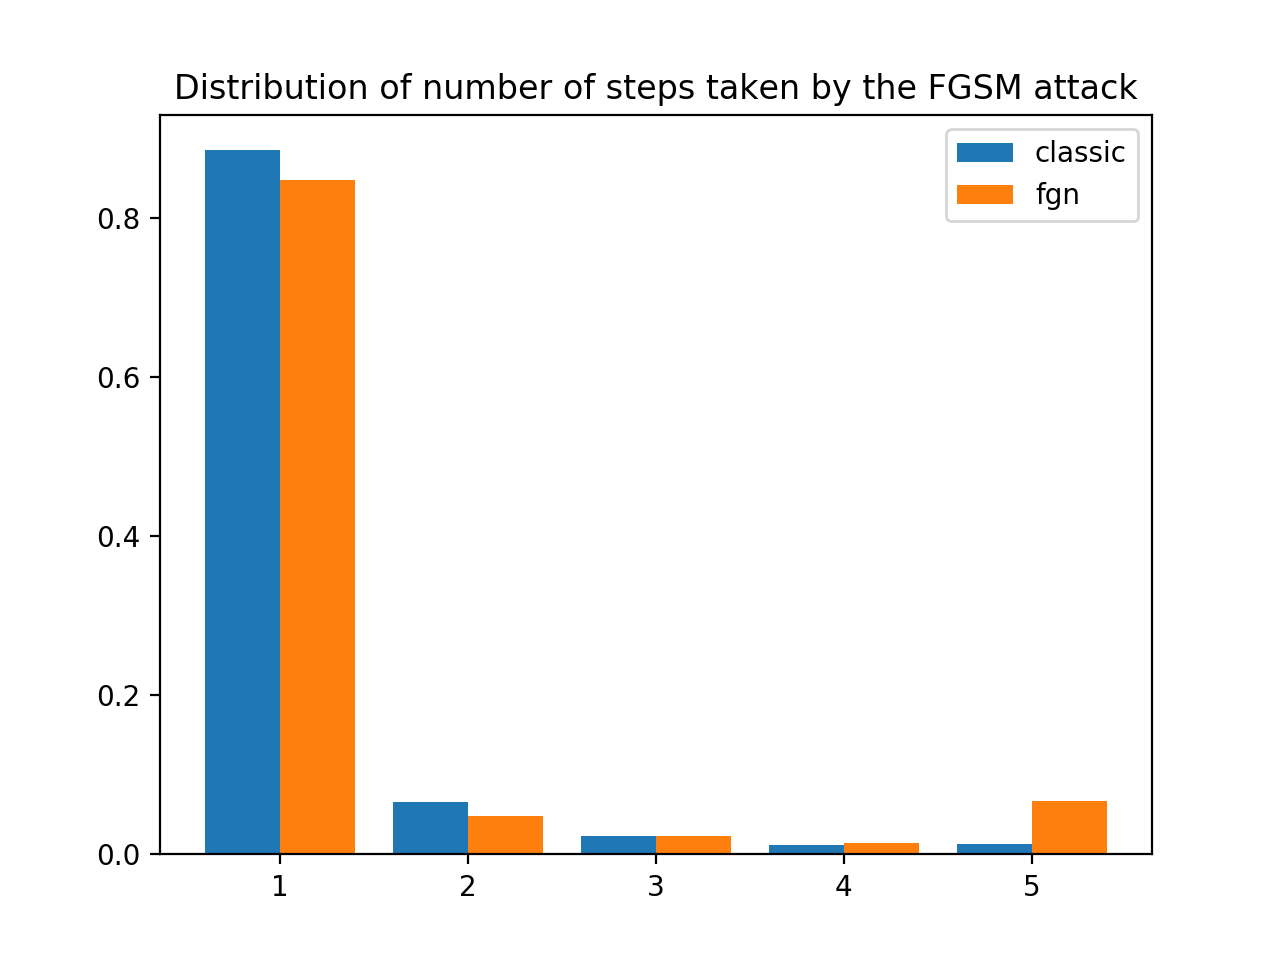

In [46]:
# plot steps distribution 
# steps taken during attacks (successful or not)
print("Classic steps stats:\n", stats.describe(classic_untargeted_steps))
print("FGN steps stats:\n", stats.describe(fgn_untargeted_steps))

# plt.hist(classic_untargeted_steps_dist, bins=range(attack_params['steps']+2), align='left',rwidth =0.9, alpha=0.5, label='classic')
# plt.hist(fgn_untargeted_steps_dist, bins=range(attack_params['steps']+2), align='left',rwidth =0.8, alpha=0.5, label='fgn')

to_plot = [classic_untargeted_steps, fgn_untargeted_steps]
plt.hist(to_plot, density=True, bins=range(attack_params['steps']+2)[1:], align='left', label=labels)

plt.title("Distribution of number of steps taken by the FGSM attack") 
plt.legend()
plt.xticks(range(attack_params['steps']+1)[1:])
plt.show()

# Targeted attacks

In [47]:
# change params for targeted attack
# attack_params = {'targeted':True, 
#                  'data_classes':list(range(10)), 
#                  'max_noise':(max_pix-min_pix)/64.0, 
#                  'data_bounds':(min_pix, max_pix),
#                  'loss_func':torch.nn.CrossEntropyLoss(), 
#                  'step_size':(max_pix-min_pix)/128.0, 
#                  'steps': 5,
#                  'confidence_req':0.5}

# num_attacks = len(mnist_val_loader.dataset.tensors[0])
# num_attacks = 10

attack_params['targeted'] = True

In [ ]:
# attack the classic net
classic_targeted_attack_results = fgnl.full_FGSM_attack(classic_model, dataloader, num_attacks=num_attacks, 
                                                          attack_params=attack_params, verbose=verbose)

In [ ]:
# extract lists
classic_targeted_confidences = classic_targeted_attack_results['confidences_list']
classic_targeted_steps = classic_targeted_attack_results['steps_list']
classic_targeted_adv_classes = classic_targeted_attack_results['adv_classes_list']
classic_targeted_successes = classic_targeted_attack_results['successes_list']

# indexes of sucessful attacks any %
classic_targeted_successes_indices_any = np.flatnonzero(classic_targeted_successes)
# above req
classic_targeted_successes_indices_req = [i
                                            for i,v in enumerate(classic_targeted_successes)
                                            if v and classic_targeted_confidences[i]>=attack_params['confidence_req']]

In [ ]:
# attack the fgn net
fgn_targeted_attack_results = fgnl.full_FGSM_attack(fgn_model, dataloader, num_attacks=num_attacks,
                                                      attack_params=attack_params, verbose=verbose)

In [ ]:
# extract lists
fgn_targeted_confidences = fgn_targeted_attack_results['confidences_list']
fgn_targeted_steps = fgn_targeted_attack_results['steps_list']
fgn_targeted_adv_classes = fgn_targeted_attack_results['adv_classes_list']
fgn_targeted_successes = fgn_targeted_attack_results['successes_list']

# indexes of sucessful attacks any %
fgn_targeted_successes_indices_any = np.flatnonzero(fgn_targeted_successes)
# above req
fgn_targeted_successes_indices_req = [i
                                            for i,v in enumerate(fgn_targeted_successes)
                                            if v and fgn_targeted_confidences[i]>=attack_params['confidence_req']]

In [ ]:
### Results

In [48]:
# success rates

print('Success rates with any confidence')
print("targeted attack on classic net success rate: {}/{}, {}%".format(len(classic_targeted_successes_indices_any),
                                                                         num_attacks,
                                                                         len(classic_targeted_successes_indices_any)/num_attacks))
print("targeted attack on FGN net success rate: {}/{}, {}%".format(len(fgn_targeted_successes_indices_any),
                                                                         num_attacks,
                                                                         len(fgn_targeted_successes_indices_any)/num_attacks))


Success rates with any confidence
targeted attack on classic net success rate: 3678/30000, 0.1226%
targeted attack on classic net success rate: 3449/30000, 0.11496666666666666%


In [49]:
# success rates above confidence

print('Success rates with confidence >= {}'.format(attack_params['confidence_req']))
print("targeted attack on classic net success rate: {}/{}, {}%".format(len(classic_targeted_successes_indices_req),
                                                                         num_attacks,
                                                                         len(classic_targeted_successes_indices_req)/num_attacks))
print("targeted attack on classic net success rate: {}/{}, {}%".format(len(fgn_targeted_successes_indices_req),
                                                                         num_attacks,
                                                                         len(fgn_targeted_successes_indices_req)/num_attacks))


Success rates with confidence >= 0.5
targeted attack on classic net success rate: 3204/30000, 0.1068%
targeted attack on classic net success rate: 1826/30000, 0.060866666666666666%


<IPython.core.display.Javascript object>


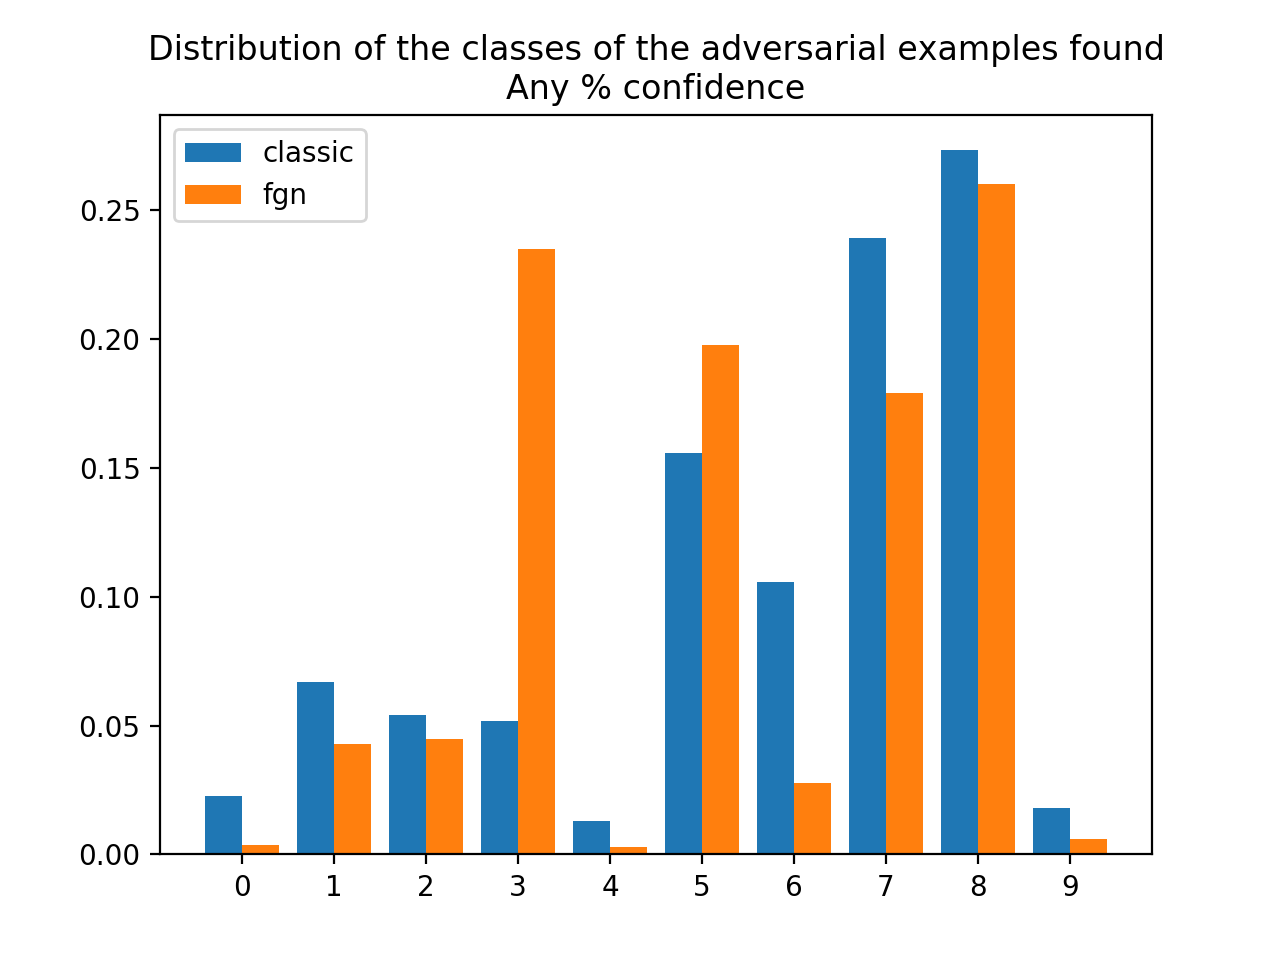

In [50]:
# adversarial class distribution
# plt.hist(classic_targeted_adv_classes, bins=range(11), align='left', rwidth=0.9, alpha=0.5, label='classic')
# plt.hist(fgn_targeted_adv_classes, bins=range(11), align='left', rwidth=0.8, alpha=0.5, label='fgn')

# plot 
tp1 = [classic_targeted_adv_classes[i] for i in classic_targeted_successes_indices_any]
tp2 = [fgn_targeted_adv_classes[i] for i in fgn_targeted_successes_indices_any]

to_plot = [tp1, tp2]
plt.hist(to_plot, bins=range(11), density=True, align='left', rwidth=0.8, alpha=1.0, label=labels)

plt.title("Distribution of the classes of the adversarial examples found\nAny % confidence") 
plt.xticks(range(10))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


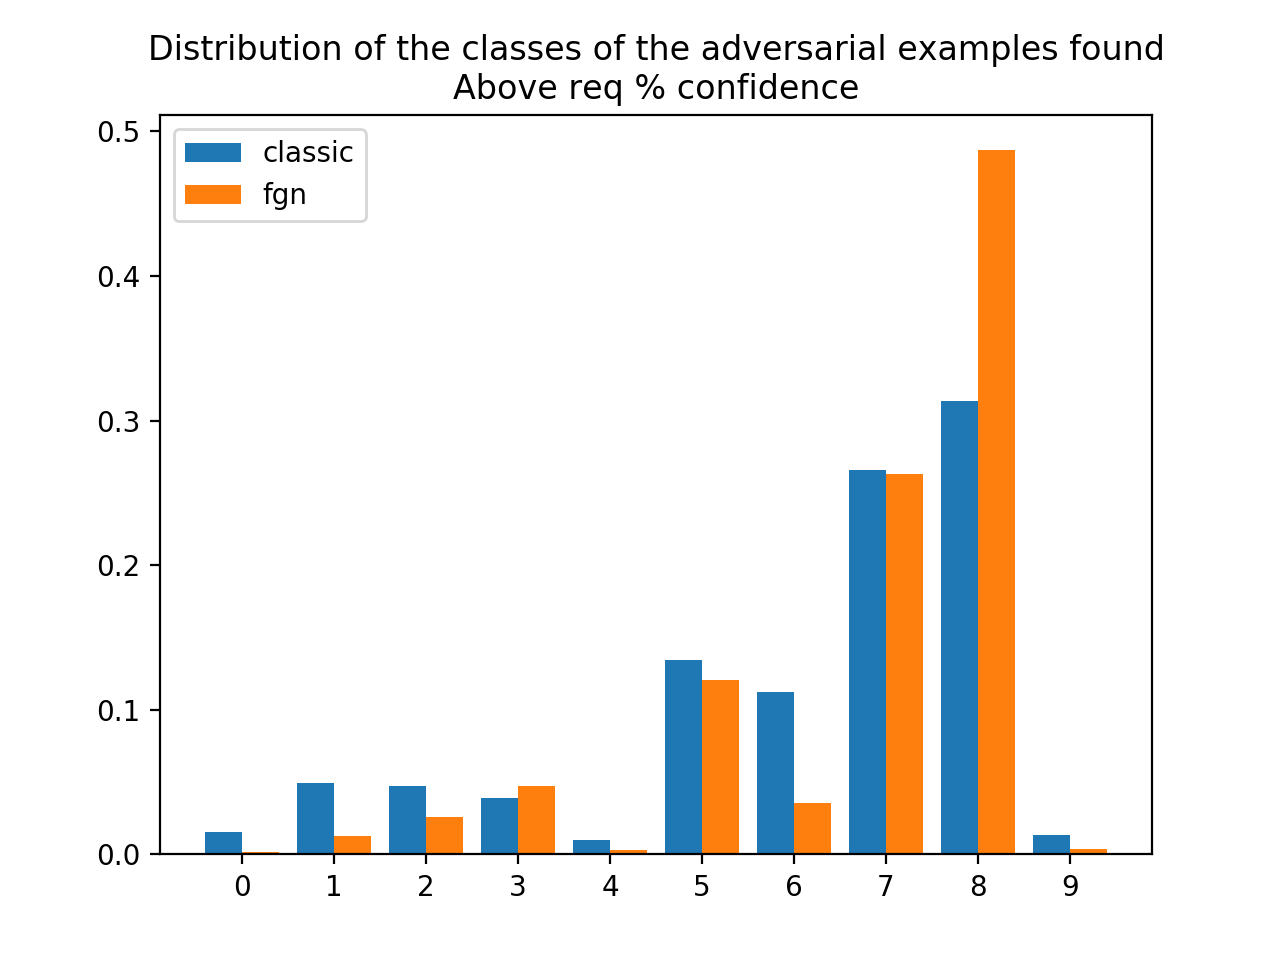

In [51]:
# adversarial class distribution
# plt.hist(classic_targeted_adv_classes, bins=range(11), align='left', rwidth=0.9, alpha=0.5, label='classic')
# plt.hist(fgn_targeted_adv_classes, bins=range(11), align='left', rwidth=0.8, alpha=0.5, label='fgn')

# plot 
tp1 = [classic_targeted_adv_classes[i] for i in classic_targeted_successes_indices_req]
tp2 = [fgn_targeted_adv_classes[i] for i in fgn_targeted_successes_indices_req]

to_plot = [tp1, tp2]
plt.hist(to_plot, bins=range(11), density=True, align='left', rwidth=0.8, alpha=1.0, label=labels)

plt.title("Distribution of the classes of the adversarial examples found\nAbove req % confidence") 
plt.xticks(range(10))
plt.legend()
plt.show()

With -1s
classic confidence stats:
 DescribeResult(nobs=10000, minmax=(-1.0, 0.9998080134391785), mean=-0.34803597492873667, variance=0.7464000099350818, skewness=0.6104604246221051, kurtosis=-1.5516769037510656)
fgn confidence stats:
 DescribeResult(nobs=10000, minmax=(-1.0, 0.9960518479347229), mean=-0.4577495432302356, variance=0.587573984923064, skewness=0.8084873742994055, kurtosis=-1.1412129204060326)

Without -1
classic confidence stats:
 DescribeResult(nobs=3678, minmax=(0.23711872, 0.999808), mean=0.7726047, variance=0.042719435, skewness=-0.5042827725410461, kurtosis=-0.8997459129710839)
fgn confidence stats:
 DescribeResult(nobs=3449, minmax=(0.14689691, 0.99605185), mean=0.5721962, variance=0.084184155, skewness=0.2403961569070816, kurtosis=-1.4549488236746013)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


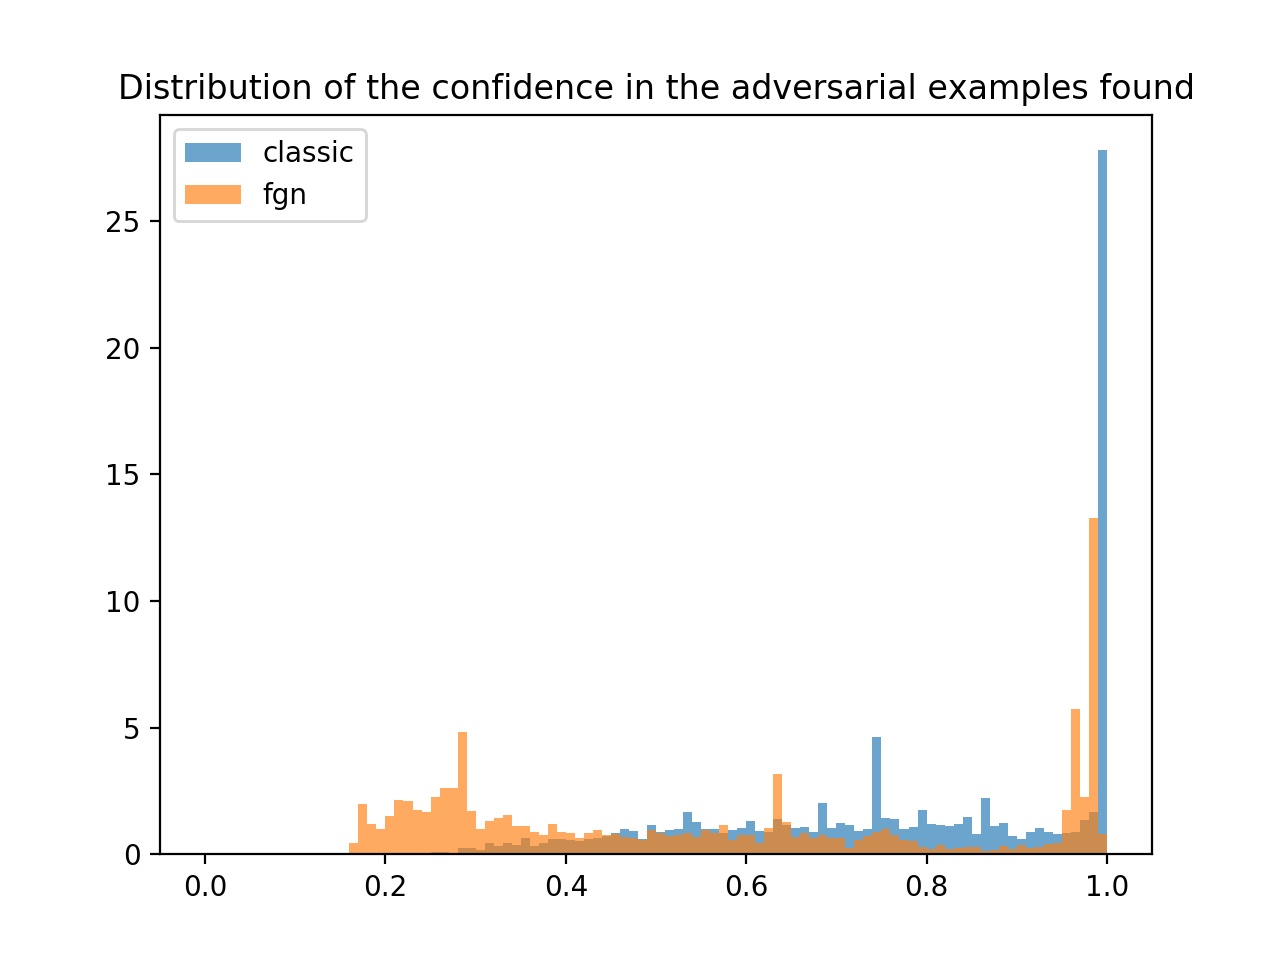

In [137]:
# plot confidence distribution
# classic_targeted_successes_confidences = [classic_targeted_confidences[i] 
#                                             for i in classic_targeted_successes_indices_any]

# fgn_targeted_successes_confidences = [fgn_targeted_confidences[i] 
#                                             for i in fgn_targeted_successes_indices_any]

print("With -1s")
print("classic confidence stats:\n", stats.describe(classic_targeted_confidences))
print("fgn confidence stats:\n", stats.describe(fgn_targeted_confidences))

print()
classic_targeted_confidences_filtered = list(filter(lambda x:x>=0, classic_targeted_confidences))
fgn_targeted_confidences_filtered = list(filter(lambda x:x>=0, fgn_targeted_confidences))


print("Without -1")
print("classic confidence stats:\n", stats.describe(classic_targeted_confidences_filtered))
print("fgn confidence stats:\n", stats.describe(fgn_targeted_confidences_filtered))

plt.hist(classic_targeted_confidences_filtered, density=True, bins=[x/100 for x in range(101)], alpha=0.66, label='classic')
plt.hist(fgn_targeted_confidences_filtered, density=True, bins=[x/100 for x in range(101)], alpha=0.66, label='fgn')

# to_plot = [striped_classic_confidence, striped_fgn_confidence]
# plt.hist(to_plot, bins=101, alpha=1.0, label=labels)

plt.title("Distribution of the confidence in the adversarial examples found") 
plt.legend()
plt.show()

Classic steps stats:
 DescribeResult(nobs=10000, minmax=(1, 5), mean=4.1061, variance=2.333876177617762, skewness=-1.3035562745370064, kurtosis=-0.07857089700849151)
FGN steps stats:
 DescribeResult(nobs=10000, minmax=(1, 5), mean=4.3644, variance=2.034216061606161, skewness=-1.8582504455122897, kurtosis=1.5303785669057524)


<IPython.core.display.Javascript object>


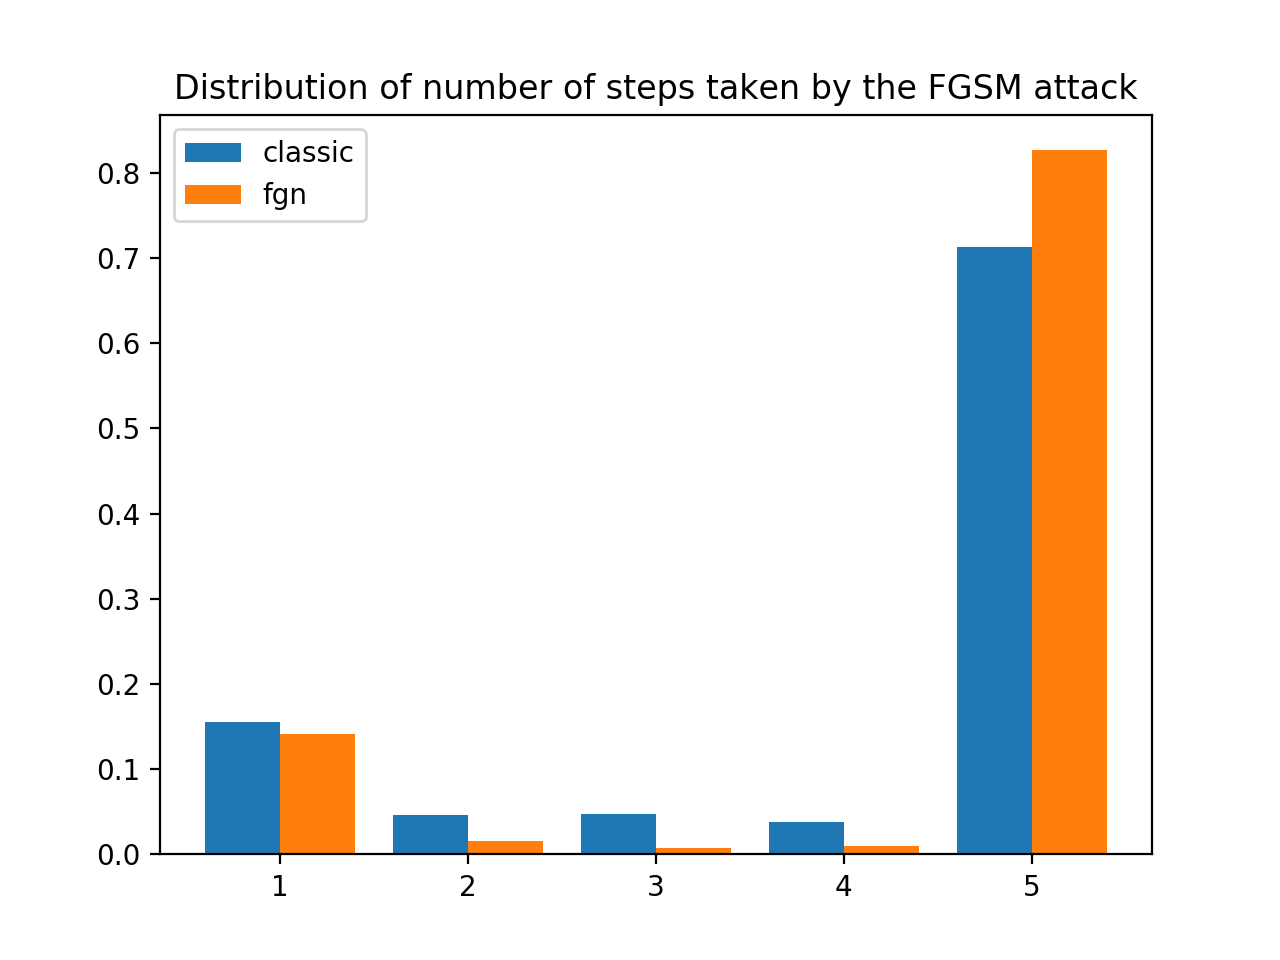

In [53]:
# plot steps distribution 
# steps taken during attacks (successful or not)
print("Classic steps stats:\n", stats.describe(classic_targeted_steps))
print("FGN steps stats:\n", stats.describe(fgn_targeted_steps))

# plt.hist(classic_targeted_steps_dist, bins=range(attack_params['steps']+2), align='left',rwidth =0.9, alpha=0.5, label='classic')
# plt.hist(fgn_targeted_steps_dist, bins=range(attack_params['steps']+2), align='left',rwidth =0.8, alpha=0.5, label='fgn')

to_plot = [classic_targeted_steps, fgn_targeted_steps]
plt.hist(to_plot, density=True, bins=range(attack_params['steps']+2)[1:], align='left', label=labels)

plt.title("Distribution of number of steps taken by the FGSM attack") 
plt.legend()
plt.xticks(range(attack_params['steps']+1)[1:])
plt.show()

# Retraining

In [55]:
import torch.optim as optim

In [130]:
# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e1
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad,fgn_model.parameters()), lr=1e-3)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 10.0


In [105]:
# train the network for N epochs
epochs = 1000
train_res = fgnh.train(fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 21237.8395, Accuracy: 48778/50000 (98%)
Test set - Average loss: 16206.9639, Accuracy: 9764/10000 (98%)
Epoch 1 Train set - Average loss: 14112.4971, Accuracy: 48694/50000 (97%)
Test set - Average loss: 11555.2490, Accuracy: 9761/10000 (98%)
Epoch 2 Train set - Average loss: 10408.2600, Accuracy: 48608/50000 (97%)
Test set - Average loss: 8962.8340, Accuracy: 9753/10000 (98%)
Epoch 3 Train set - Average loss: 8273.0689, Accuracy: 48567/50000 (97%)
Test set - Average loss: 7381.0127, Accuracy: 9745/10000 (97%)
Epoch 4 Train set - Average loss: 6933.6780, Accuracy: 48423/50000 (97%)
Test set - Average loss: 6342.6851, Accuracy: 9734/10000 (97%)
Epoch 5 Train set - Average loss: 6034.1772, Accuracy: 48391/50000 (97%)
Test set - Average loss: 5619.1641, Accuracy: 9732/10000 (97%)
Epoch 6 Train set - Average loss: 5395.1820, Accuracy: 48277/50000 (97%)
Test set - Average loss: 5089.0898, Accuracy: 9724/10000 (97%)
Epoch 7 Train set - Average loss: 4919.1906

Epoch 60 Train set - Average loss: 1310.4547, Accuracy: 47847/50000 (96%)
Test set - Average loss: 1301.0581, Accuracy: 9677/10000 (97%)
Epoch 61 Train set - Average loss: 1295.1478, Accuracy: 47960/50000 (96%)
Test set - Average loss: 1285.9973, Accuracy: 9682/10000 (97%)
Epoch 62 Train set - Average loss: 1280.2411, Accuracy: 47968/50000 (96%)
Test set - Average loss: 1271.3224, Accuracy: 9684/10000 (97%)
Epoch 63 Train set - Average loss: 1265.7125, Accuracy: 47936/50000 (96%)
Test set - Average loss: 1257.0179, Accuracy: 9686/10000 (97%)
Epoch 64 Train set - Average loss: 1251.5456, Accuracy: 47900/50000 (96%)
Test set - Average loss: 1243.0687, Accuracy: 9682/10000 (97%)
Epoch 65 Train set - Average loss: 1237.7301, Accuracy: 47970/50000 (96%)
Test set - Average loss: 1229.4613, Accuracy: 9682/10000 (97%)
Epoch 66 Train set - Average loss: 1224.2503, Accuracy: 48039/50000 (96%)
Test set - Average loss: 1216.1829, Accuracy: 9683/10000 (97%)
Epoch 67 Train set - Average loss: 1211.0

Test set - Average loss: 782.7543, Accuracy: 9711/10000 (97%)
Epoch 121 Train set - Average loss: 780.8066, Accuracy: 48318/50000 (97%)
Test set - Average loss: 777.8149, Accuracy: 9707/10000 (97%)
Epoch 122 Train set - Average loss: 775.8927, Accuracy: 48337/50000 (97%)
Test set - Average loss: 772.9422, Accuracy: 9709/10000 (97%)
Epoch 123 Train set - Average loss: 771.0420, Accuracy: 48406/50000 (97%)
Test set - Average loss: 768.1351, Accuracy: 9714/10000 (97%)
Epoch 124 Train set - Average loss: 766.2597, Accuracy: 48383/50000 (97%)
Test set - Average loss: 763.3924, Accuracy: 9710/10000 (97%)
Epoch 125 Train set - Average loss: 761.5448, Accuracy: 48357/50000 (97%)
Test set - Average loss: 758.7108, Accuracy: 9709/10000 (97%)
Epoch 126 Train set - Average loss: 756.8873, Accuracy: 48332/50000 (97%)
Test set - Average loss: 754.0919, Accuracy: 9709/10000 (97%)
Epoch 127 Train set - Average loss: 752.2907, Accuracy: 48308/50000 (97%)
Test set - Average loss: 749.5337, Accuracy: 971

Epoch 181 Train set - Average loss: 569.1867, Accuracy: 48448/50000 (97%)
Test set - Average loss: 567.6683, Accuracy: 9718/10000 (97%)
Epoch 182 Train set - Average loss: 566.6664, Accuracy: 48478/50000 (97%)
Test set - Average loss: 565.1636, Accuracy: 9720/10000 (97%)
Epoch 183 Train set - Average loss: 564.1687, Accuracy: 48547/50000 (97%)
Test set - Average loss: 562.6810, Accuracy: 9721/10000 (97%)
Epoch 184 Train set - Average loss: 561.6948, Accuracy: 48471/50000 (97%)
Test set - Average loss: 560.2220, Accuracy: 9720/10000 (97%)
Epoch 185 Train set - Average loss: 559.2415, Accuracy: 48522/50000 (97%)
Test set - Average loss: 557.7835, Accuracy: 9719/10000 (97%)
Epoch 186 Train set - Average loss: 556.8143, Accuracy: 48534/50000 (97%)
Test set - Average loss: 555.3660, Accuracy: 9724/10000 (97%)
Epoch 187 Train set - Average loss: 554.4065, Accuracy: 48482/50000 (97%)
Test set - Average loss: 552.9714, Accuracy: 9722/10000 (97%)
Epoch 188 Train set - Average loss: 552.0194, Ac

Test set - Average loss: 448.9236, Accuracy: 9743/10000 (97%)
Epoch 242 Train set - Average loss: 448.2874, Accuracy: 48596/50000 (97%)
Test set - Average loss: 447.3664, Accuracy: 9744/10000 (97%)
Epoch 243 Train set - Average loss: 446.7379, Accuracy: 48565/50000 (97%)
Test set - Average loss: 445.8206, Accuracy: 9745/10000 (97%)
Epoch 244 Train set - Average loss: 445.1942, Accuracy: 48597/50000 (97%)
Test set - Average loss: 444.2843, Accuracy: 9743/10000 (97%)
Epoch 245 Train set - Average loss: 443.6614, Accuracy: 48581/50000 (97%)
Test set - Average loss: 442.7606, Accuracy: 9741/10000 (97%)
Epoch 246 Train set - Average loss: 442.1395, Accuracy: 48676/50000 (97%)
Test set - Average loss: 441.2467, Accuracy: 9747/10000 (97%)
Epoch 247 Train set - Average loss: 440.6317, Accuracy: 48586/50000 (97%)
Test set - Average loss: 439.7418, Accuracy: 9743/10000 (97%)
Epoch 248 Train set - Average loss: 439.1295, Accuracy: 48628/50000 (97%)
Test set - Average loss: 438.2486, Accuracy: 974

Epoch 302 Train set - Average loss: 370.7050, Accuracy: 48671/50000 (97%)
Test set - Average loss: 370.0775, Accuracy: 9749/10000 (97%)
Epoch 303 Train set - Average loss: 369.6307, Accuracy: 48717/50000 (97%)
Test set - Average loss: 369.0089, Accuracy: 9748/10000 (97%)
Epoch 304 Train set - Average loss: 368.5650, Accuracy: 48690/50000 (97%)
Test set - Average loss: 367.9454, Accuracy: 9758/10000 (98%)
Epoch 305 Train set - Average loss: 367.5028, Accuracy: 48697/50000 (97%)
Test set - Average loss: 366.8870, Accuracy: 9757/10000 (98%)
Epoch 306 Train set - Average loss: 366.4507, Accuracy: 48665/50000 (97%)
Test set - Average loss: 365.8354, Accuracy: 9756/10000 (98%)
Epoch 307 Train set - Average loss: 365.3974, Accuracy: 48732/50000 (97%)
Test set - Average loss: 364.7901, Accuracy: 9760/10000 (98%)
Epoch 308 Train set - Average loss: 364.3550, Accuracy: 48745/50000 (97%)
Test set - Average loss: 363.7494, Accuracy: 9754/10000 (98%)
Epoch 309 Train set - Average loss: 363.3186, Ac

Epoch 363 Train set - Average loss: 314.4571, Accuracy: 48794/50000 (98%)
Test set - Average loss: 314.0016, Accuracy: 9762/10000 (98%)
Epoch 364 Train set - Average loss: 313.6663, Accuracy: 48829/50000 (98%)
Test set - Average loss: 313.2138, Accuracy: 9764/10000 (98%)
Epoch 365 Train set - Average loss: 312.8799, Accuracy: 48833/50000 (98%)
Test set - Average loss: 312.4300, Accuracy: 9770/10000 (98%)
Epoch 366 Train set - Average loss: 312.0996, Accuracy: 48792/50000 (98%)
Test set - Average loss: 311.6510, Accuracy: 9769/10000 (98%)
Epoch 367 Train set - Average loss: 311.3171, Accuracy: 48860/50000 (98%)
Test set - Average loss: 310.8743, Accuracy: 9760/10000 (98%)
Epoch 368 Train set - Average loss: 310.5431, Accuracy: 48820/50000 (98%)
Test set - Average loss: 310.0995, Accuracy: 9770/10000 (98%)
Epoch 369 Train set - Average loss: 309.7713, Accuracy: 48821/50000 (98%)
Test set - Average loss: 309.3289, Accuracy: 9770/10000 (98%)
Epoch 370 Train set - Average loss: 309.0008, Ac

Test set - Average loss: 272.3075, Accuracy: 9775/10000 (98%)
Epoch 424 Train set - Average loss: 272.0444, Accuracy: 48845/50000 (98%)
Test set - Average loss: 271.6966, Accuracy: 9769/10000 (98%)
Epoch 425 Train set - Average loss: 271.4332, Accuracy: 48918/50000 (98%)
Test set - Average loss: 271.0895, Accuracy: 9771/10000 (98%)
Epoch 426 Train set - Average loss: 270.8226, Accuracy: 48928/50000 (98%)
Test set - Average loss: 270.4821, Accuracy: 9768/10000 (98%)
Epoch 427 Train set - Average loss: 270.2198, Accuracy: 48902/50000 (98%)
Test set - Average loss: 269.8771, Accuracy: 9773/10000 (98%)
Epoch 428 Train set - Average loss: 269.6180, Accuracy: 48887/50000 (98%)
Test set - Average loss: 269.2751, Accuracy: 9773/10000 (98%)
Epoch 429 Train set - Average loss: 269.0168, Accuracy: 48874/50000 (98%)
Test set - Average loss: 268.6759, Accuracy: 9775/10000 (98%)
Epoch 430 Train set - Average loss: 268.4176, Accuracy: 48900/50000 (98%)
Test set - Average loss: 268.0796, Accuracy: 977

Epoch 484 Train set - Average loss: 239.1879, Accuracy: 48950/50000 (98%)
Test set - Average loss: 238.9122, Accuracy: 9781/10000 (98%)
Epoch 485 Train set - Average loss: 238.6953, Accuracy: 49002/50000 (98%)
Test set - Average loss: 238.4249, Accuracy: 9770/10000 (98%)
Epoch 486 Train set - Average loss: 238.2086, Accuracy: 49008/50000 (98%)
Test set - Average loss: 237.9369, Accuracy: 9778/10000 (98%)
Epoch 487 Train set - Average loss: 237.7222, Accuracy: 48980/50000 (98%)
Test set - Average loss: 237.4500, Accuracy: 9781/10000 (98%)
Epoch 488 Train set - Average loss: 237.2375, Accuracy: 48983/50000 (98%)
Test set - Average loss: 236.9670, Accuracy: 9783/10000 (98%)
Epoch 489 Train set - Average loss: 236.7538, Accuracy: 48983/50000 (98%)
Test set - Average loss: 236.4855, Accuracy: 9778/10000 (98%)
Epoch 490 Train set - Average loss: 236.2717, Accuracy: 48980/50000 (98%)
Test set - Average loss: 236.0031, Accuracy: 9785/10000 (98%)
Epoch 491 Train set - Average loss: 235.7926, Ac

Test set - Average loss: 212.2386, Accuracy: 9795/10000 (98%)
Epoch 545 Train set - Average loss: 212.0593, Accuracy: 49038/50000 (98%)
Test set - Average loss: 211.8353, Accuracy: 9789/10000 (98%)
Epoch 546 Train set - Average loss: 211.6578, Accuracy: 49038/50000 (98%)
Test set - Average loss: 211.4323, Accuracy: 9787/10000 (98%)
Epoch 547 Train set - Average loss: 211.2539, Accuracy: 49044/50000 (98%)
Test set - Average loss: 211.0332, Accuracy: 9791/10000 (98%)
Epoch 548 Train set - Average loss: 210.8550, Accuracy: 49053/50000 (98%)
Test set - Average loss: 210.6347, Accuracy: 9784/10000 (98%)
Epoch 549 Train set - Average loss: 210.4572, Accuracy: 49018/50000 (98%)
Test set - Average loss: 210.2352, Accuracy: 9792/10000 (98%)
Epoch 550 Train set - Average loss: 210.0579, Accuracy: 49026/50000 (98%)
Test set - Average loss: 209.8374, Accuracy: 9790/10000 (98%)
Epoch 551 Train set - Average loss: 209.6624, Accuracy: 49017/50000 (98%)
Test set - Average loss: 209.4438, Accuracy: 978

Epoch 605 Train set - Average loss: 189.8800, Accuracy: 49061/50000 (98%)
Test set - Average loss: 189.6958, Accuracy: 9791/10000 (98%)
Epoch 606 Train set - Average loss: 189.5404, Accuracy: 49075/50000 (98%)
Test set - Average loss: 189.3562, Accuracy: 9795/10000 (98%)
Epoch 607 Train set - Average loss: 189.2012, Accuracy: 49104/50000 (98%)
Test set - Average loss: 189.0195, Accuracy: 9793/10000 (98%)
Epoch 608 Train set - Average loss: 188.8657, Accuracy: 49068/50000 (98%)
Test set - Average loss: 188.6839, Accuracy: 9791/10000 (98%)
Epoch 609 Train set - Average loss: 188.5297, Accuracy: 49086/50000 (98%)
Test set - Average loss: 188.3480, Accuracy: 9790/10000 (98%)
Epoch 610 Train set - Average loss: 188.1960, Accuracy: 49014/50000 (98%)
Test set - Average loss: 188.0125, Accuracy: 9793/10000 (98%)
Epoch 611 Train set - Average loss: 187.8605, Accuracy: 49055/50000 (98%)
Test set - Average loss: 187.6817, Accuracy: 9783/10000 (98%)
Epoch 612 Train set - Average loss: 187.5270, Ac

Epoch 666 Train set - Average loss: 170.7813, Accuracy: 49080/50000 (98%)
Test set - Average loss: 170.6303, Accuracy: 9790/10000 (98%)
Epoch 667 Train set - Average loss: 170.4920, Accuracy: 49130/50000 (98%)
Test set - Average loss: 170.3402, Accuracy: 9793/10000 (98%)
Epoch 668 Train set - Average loss: 170.2041, Accuracy: 49105/50000 (98%)
Test set - Average loss: 170.0523, Accuracy: 9792/10000 (98%)
Epoch 669 Train set - Average loss: 169.9168, Accuracy: 49113/50000 (98%)
Test set - Average loss: 169.7643, Accuracy: 9799/10000 (98%)
Epoch 670 Train set - Average loss: 169.6289, Accuracy: 49155/50000 (98%)
Test set - Average loss: 169.4798, Accuracy: 9798/10000 (98%)
Epoch 671 Train set - Average loss: 169.3450, Accuracy: 49115/50000 (98%)
Test set - Average loss: 169.1918, Accuracy: 9797/10000 (98%)
Epoch 672 Train set - Average loss: 169.0590, Accuracy: 49118/50000 (98%)
Test set - Average loss: 168.9065, Accuracy: 9805/10000 (98%)
Epoch 673 Train set - Average loss: 168.7746, Ac

Test set - Average loss: 154.5080, Accuracy: 9800/10000 (98%)
Epoch 727 Train set - Average loss: 154.3834, Accuracy: 49201/50000 (98%)
Test set - Average loss: 154.2588, Accuracy: 9798/10000 (98%)
Epoch 728 Train set - Average loss: 154.1368, Accuracy: 49143/50000 (98%)
Test set - Average loss: 154.0081, Accuracy: 9801/10000 (98%)
Epoch 729 Train set - Average loss: 153.8853, Accuracy: 49203/50000 (98%)
Test set - Average loss: 153.7625, Accuracy: 9800/10000 (98%)
Epoch 730 Train set - Average loss: 153.6393, Accuracy: 49130/50000 (98%)
Test set - Average loss: 153.5121, Accuracy: 9800/10000 (98%)
Epoch 731 Train set - Average loss: 153.3909, Accuracy: 49163/50000 (98%)
Test set - Average loss: 153.2643, Accuracy: 9796/10000 (98%)
Epoch 732 Train set - Average loss: 153.1424, Accuracy: 49186/50000 (98%)
Test set - Average loss: 153.0146, Accuracy: 9797/10000 (98%)
Epoch 733 Train set - Average loss: 152.8965, Accuracy: 49161/50000 (98%)
Test set - Average loss: 152.7689, Accuracy: 980

Epoch 787 Train set - Average loss: 140.3564, Accuracy: 49186/50000 (98%)
Test set - Average loss: 140.2493, Accuracy: 9803/10000 (98%)
Epoch 788 Train set - Average loss: 140.1369, Accuracy: 49175/50000 (98%)
Test set - Average loss: 140.0310, Accuracy: 9799/10000 (98%)
Epoch 789 Train set - Average loss: 139.9187, Accuracy: 49215/50000 (98%)
Test set - Average loss: 139.8108, Accuracy: 9801/10000 (98%)
Epoch 790 Train set - Average loss: 139.7001, Accuracy: 49188/50000 (98%)
Test set - Average loss: 139.5926, Accuracy: 9799/10000 (98%)
Epoch 791 Train set - Average loss: 139.4847, Accuracy: 49218/50000 (98%)
Test set - Average loss: 139.3759, Accuracy: 9802/10000 (98%)
Epoch 792 Train set - Average loss: 139.2686, Accuracy: 49187/50000 (98%)
Test set - Average loss: 139.1606, Accuracy: 9800/10000 (98%)
Epoch 793 Train set - Average loss: 139.0530, Accuracy: 49176/50000 (98%)
Test set - Average loss: 138.9452, Accuracy: 9797/10000 (98%)
Epoch 794 Train set - Average loss: 138.8347, Ac

Test set - Average loss: 127.9210, Accuracy: 9804/10000 (98%)
Epoch 848 Train set - Average loss: 127.8217, Accuracy: 49238/50000 (98%)
Test set - Average loss: 127.7302, Accuracy: 9806/10000 (98%)
Epoch 849 Train set - Average loss: 127.6301, Accuracy: 49213/50000 (98%)
Test set - Average loss: 127.5413, Accuracy: 9797/10000 (98%)
Epoch 850 Train set - Average loss: 127.4375, Accuracy: 49205/50000 (98%)
Test set - Average loss: 127.3510, Accuracy: 9787/10000 (98%)
Epoch 851 Train set - Average loss: 127.2455, Accuracy: 49231/50000 (98%)
Test set - Average loss: 127.1568, Accuracy: 9797/10000 (98%)
Epoch 852 Train set - Average loss: 127.0528, Accuracy: 49201/50000 (98%)
Test set - Average loss: 126.9640, Accuracy: 9803/10000 (98%)
Epoch 853 Train set - Average loss: 126.8620, Accuracy: 49234/50000 (98%)
Test set - Average loss: 126.7728, Accuracy: 9803/10000 (98%)
Epoch 854 Train set - Average loss: 126.6748, Accuracy: 49155/50000 (98%)
Test set - Average loss: 126.5813, Accuracy: 979

Epoch 908 Train set - Average loss: 116.9009, Accuracy: 49248/50000 (98%)
Test set - Average loss: 116.8255, Accuracy: 9798/10000 (98%)
Epoch 909 Train set - Average loss: 116.7302, Accuracy: 49209/50000 (98%)
Test set - Average loss: 116.6535, Accuracy: 9803/10000 (98%)
Epoch 910 Train set - Average loss: 116.5584, Accuracy: 49257/50000 (99%)
Test set - Average loss: 116.4823, Accuracy: 9808/10000 (98%)
Epoch 911 Train set - Average loss: 116.3868, Accuracy: 49266/50000 (99%)
Test set - Average loss: 116.3132, Accuracy: 9799/10000 (98%)
Epoch 912 Train set - Average loss: 116.2187, Accuracy: 49192/50000 (98%)
Test set - Average loss: 116.1407, Accuracy: 9807/10000 (98%)
Epoch 913 Train set - Average loss: 116.0485, Accuracy: 49208/50000 (98%)
Test set - Average loss: 115.9709, Accuracy: 9804/10000 (98%)
Epoch 914 Train set - Average loss: 115.8780, Accuracy: 49214/50000 (98%)
Test set - Average loss: 115.7997, Accuracy: 9808/10000 (98%)
Epoch 915 Train set - Average loss: 115.7073, Ac

Epoch 969 Train set - Average loss: 106.9971, Accuracy: 49239/50000 (98%)
Test set - Average loss: 106.9343, Accuracy: 9798/10000 (98%)
Epoch 970 Train set - Average loss: 106.8449, Accuracy: 49256/50000 (99%)
Test set - Average loss: 106.7805, Accuracy: 9804/10000 (98%)
Epoch 971 Train set - Average loss: 106.6905, Accuracy: 49262/50000 (99%)
Test set - Average loss: 106.6246, Accuracy: 9813/10000 (98%)
Epoch 972 Train set - Average loss: 106.5378, Accuracy: 49250/50000 (98%)
Test set - Average loss: 106.4715, Accuracy: 9805/10000 (98%)
Epoch 973 Train set - Average loss: 106.3872, Accuracy: 49225/50000 (98%)
Test set - Average loss: 106.3193, Accuracy: 9807/10000 (98%)
Epoch 974 Train set - Average loss: 106.2339, Accuracy: 49241/50000 (98%)
Test set - Average loss: 106.1666, Accuracy: 9810/10000 (98%)
Epoch 975 Train set - Average loss: 106.0820, Accuracy: 49248/50000 (98%)
Test set - Average loss: 106.0167, Accuracy: 9802/10000 (98%)
Epoch 976 Train set - Average loss: 105.9286, Ac

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


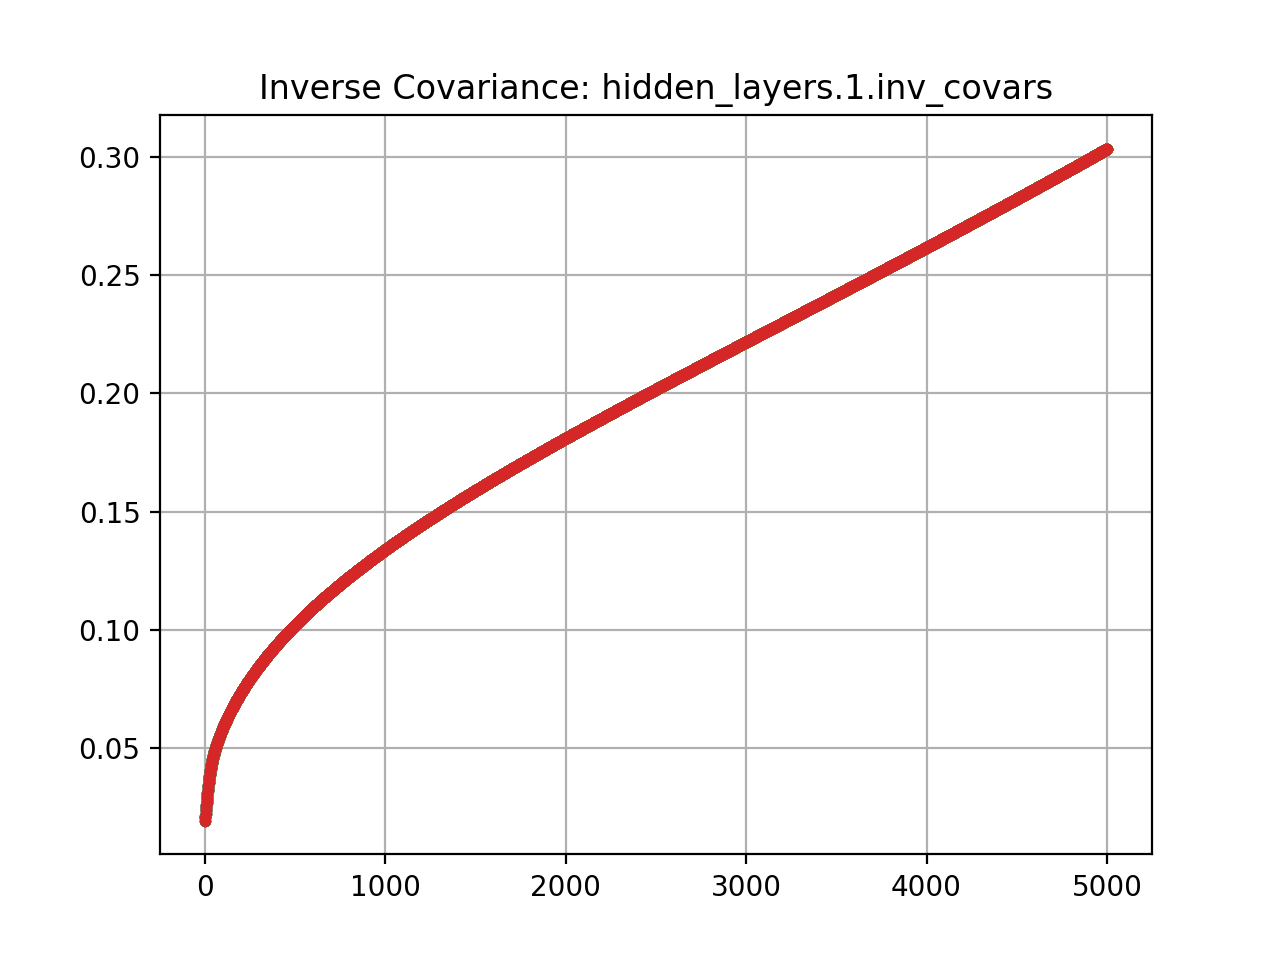

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


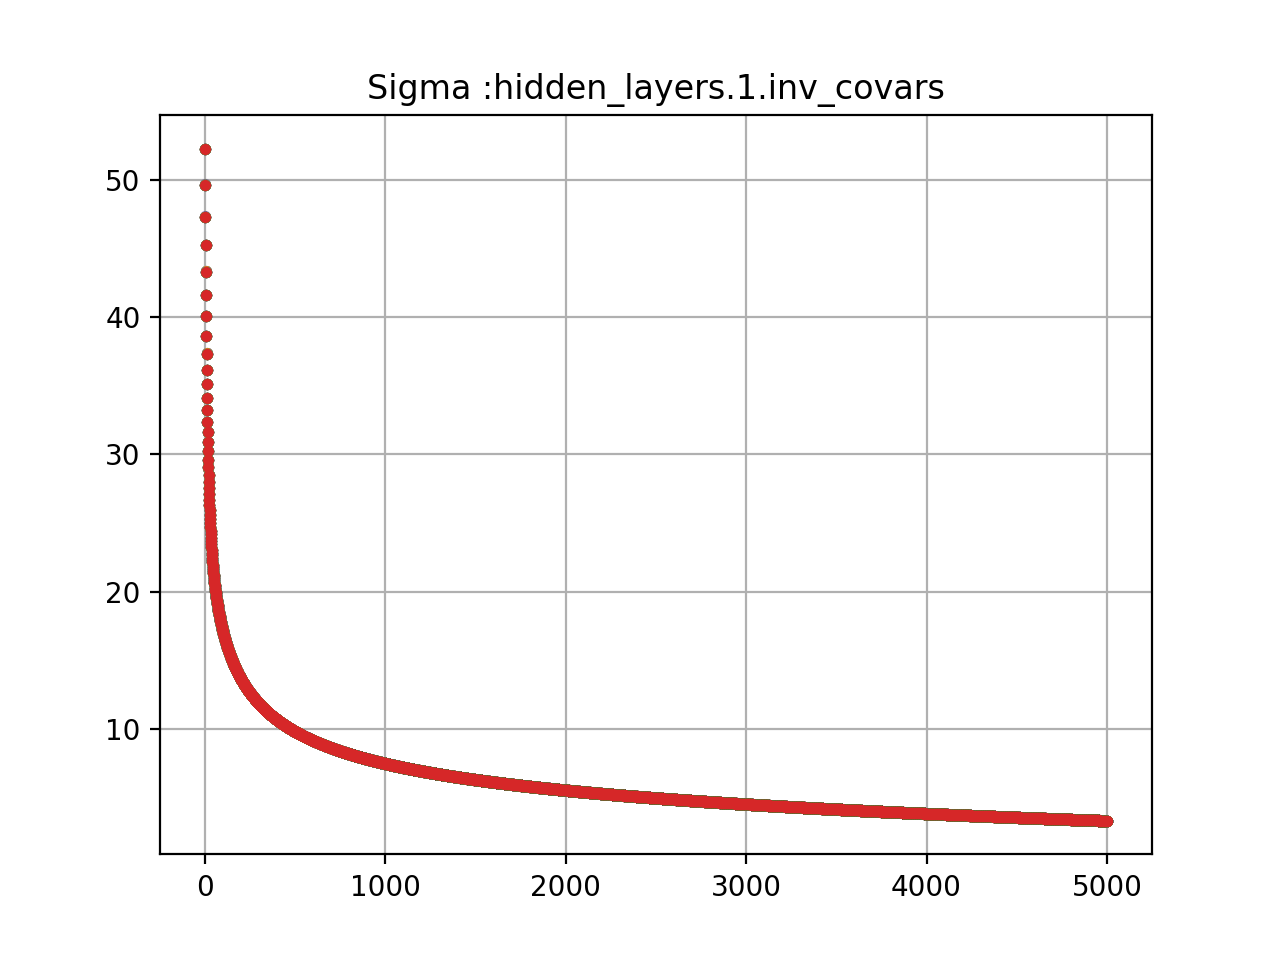

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


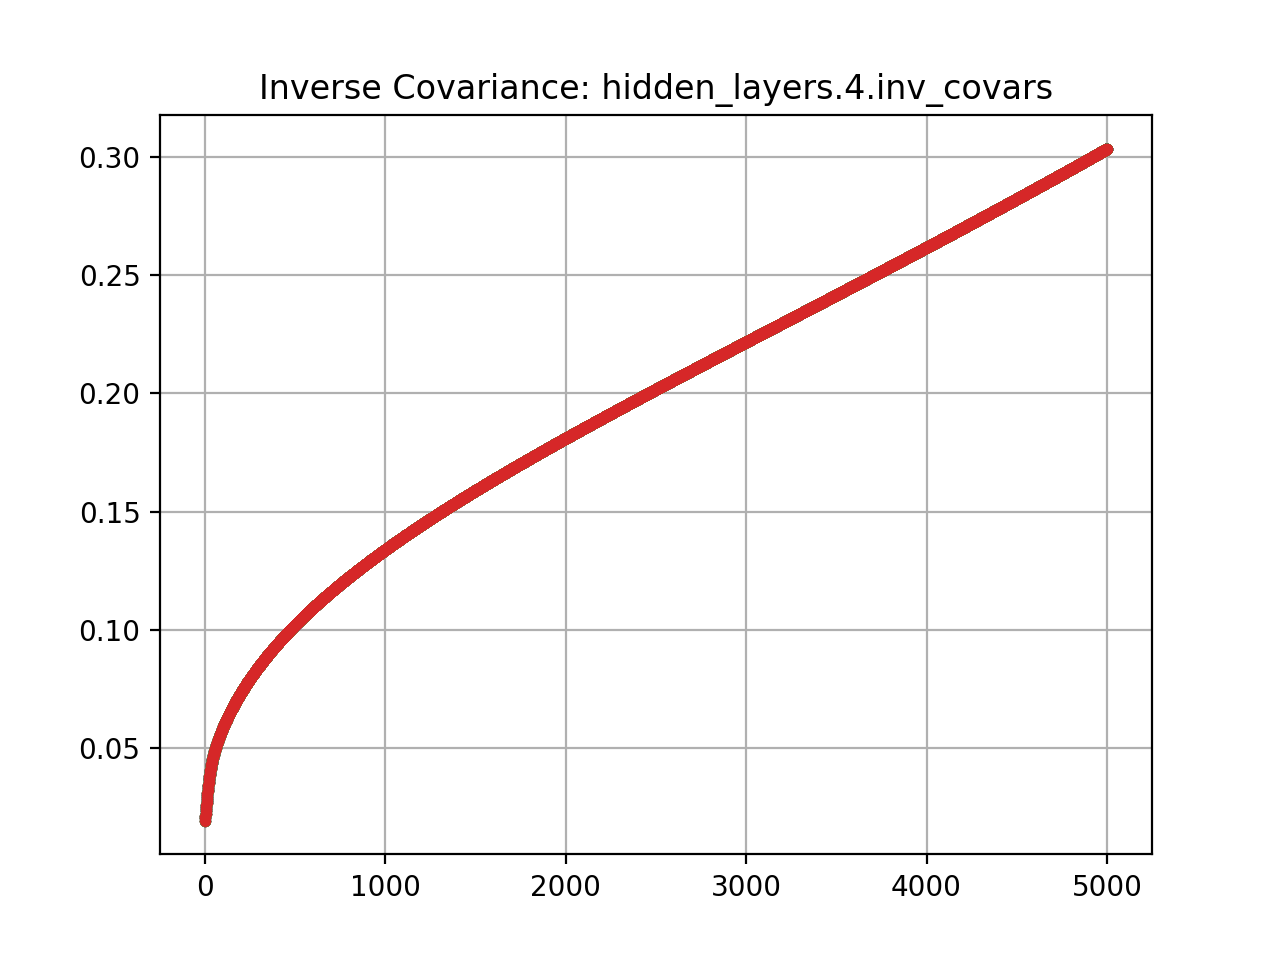

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


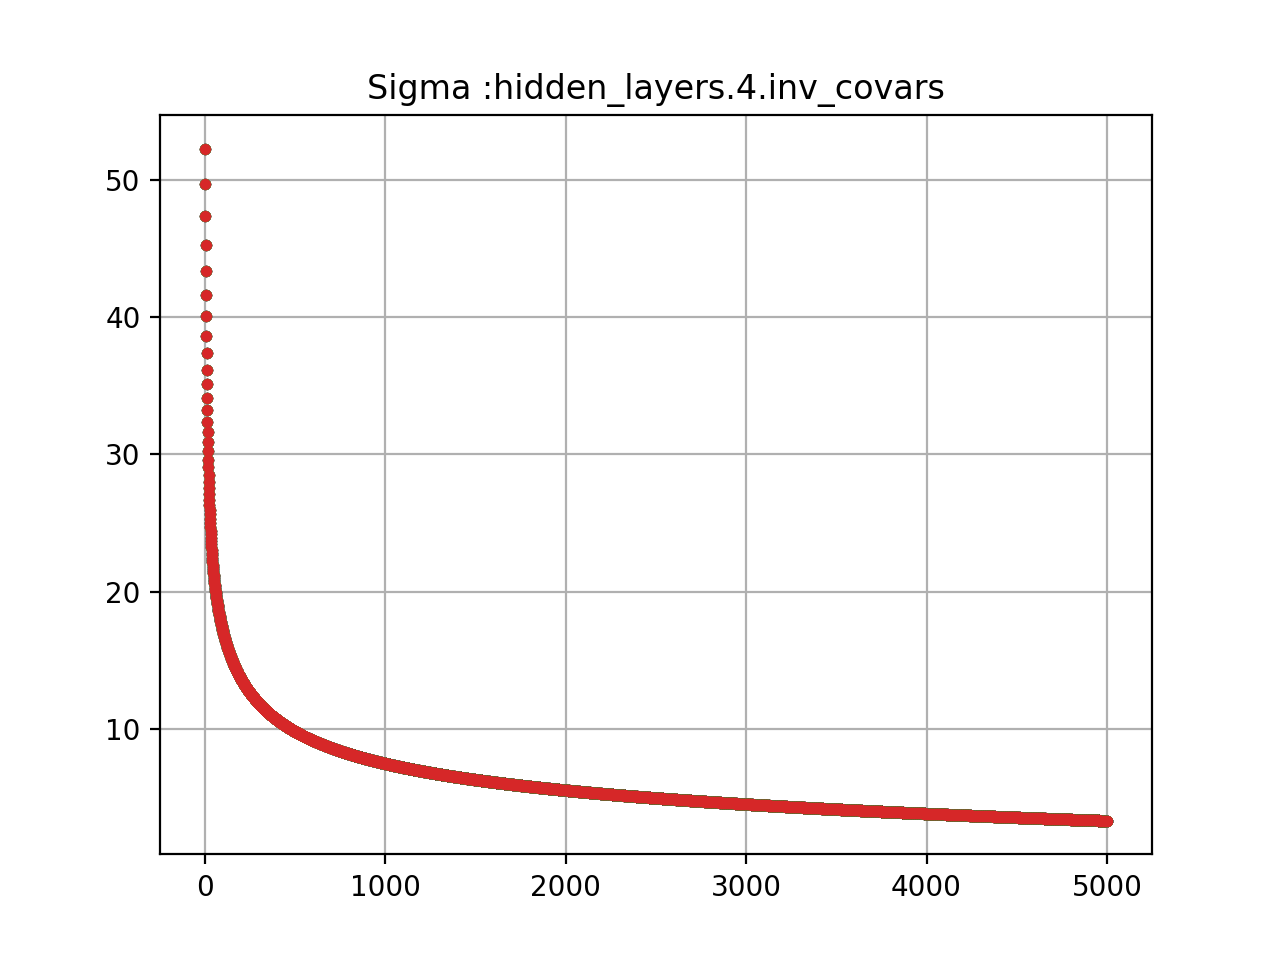

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(histories[k], marker='.', linestyle=' ',)


<IPython.core.display.Javascript object>


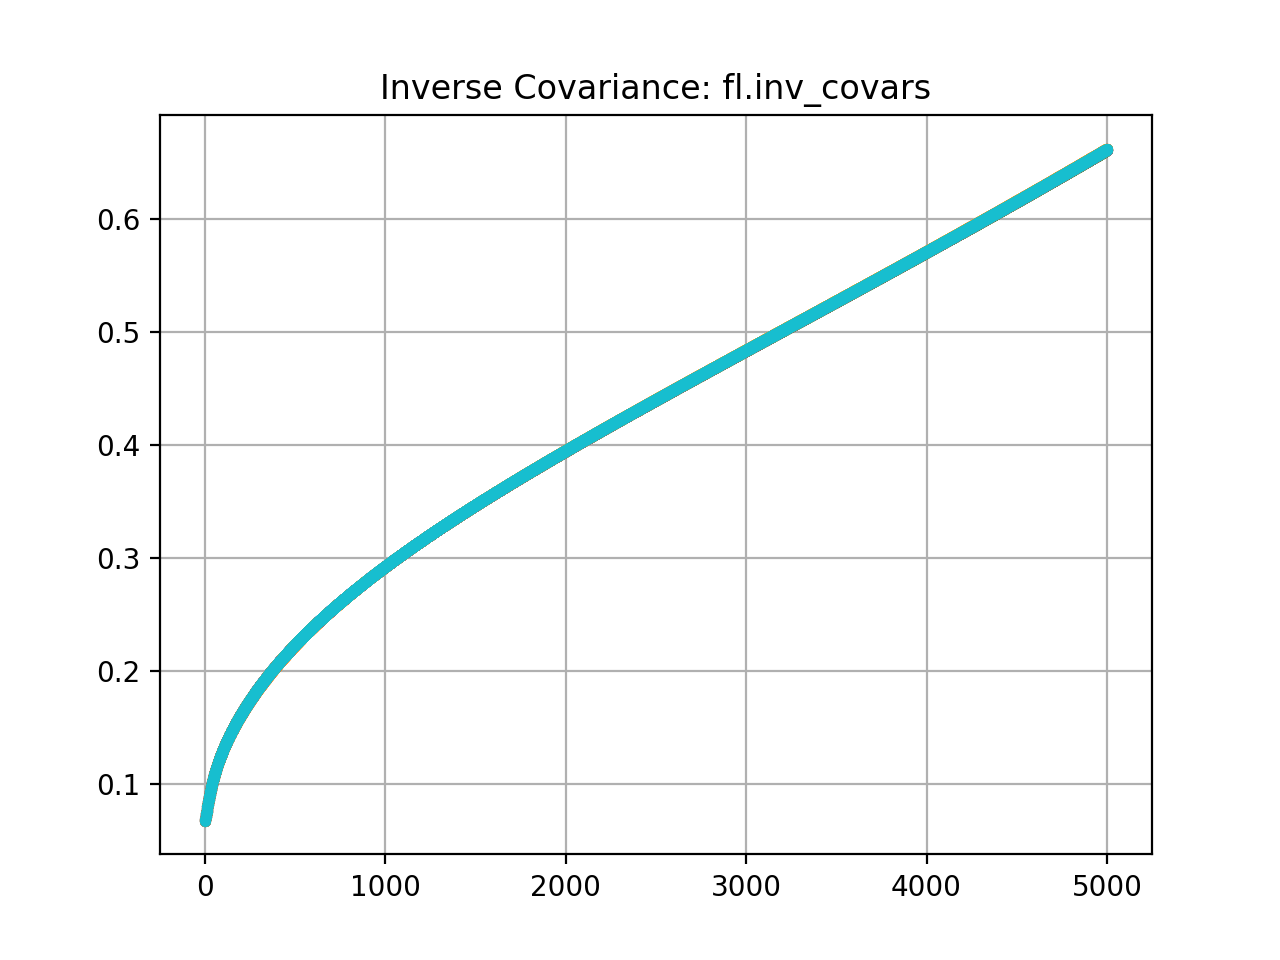

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


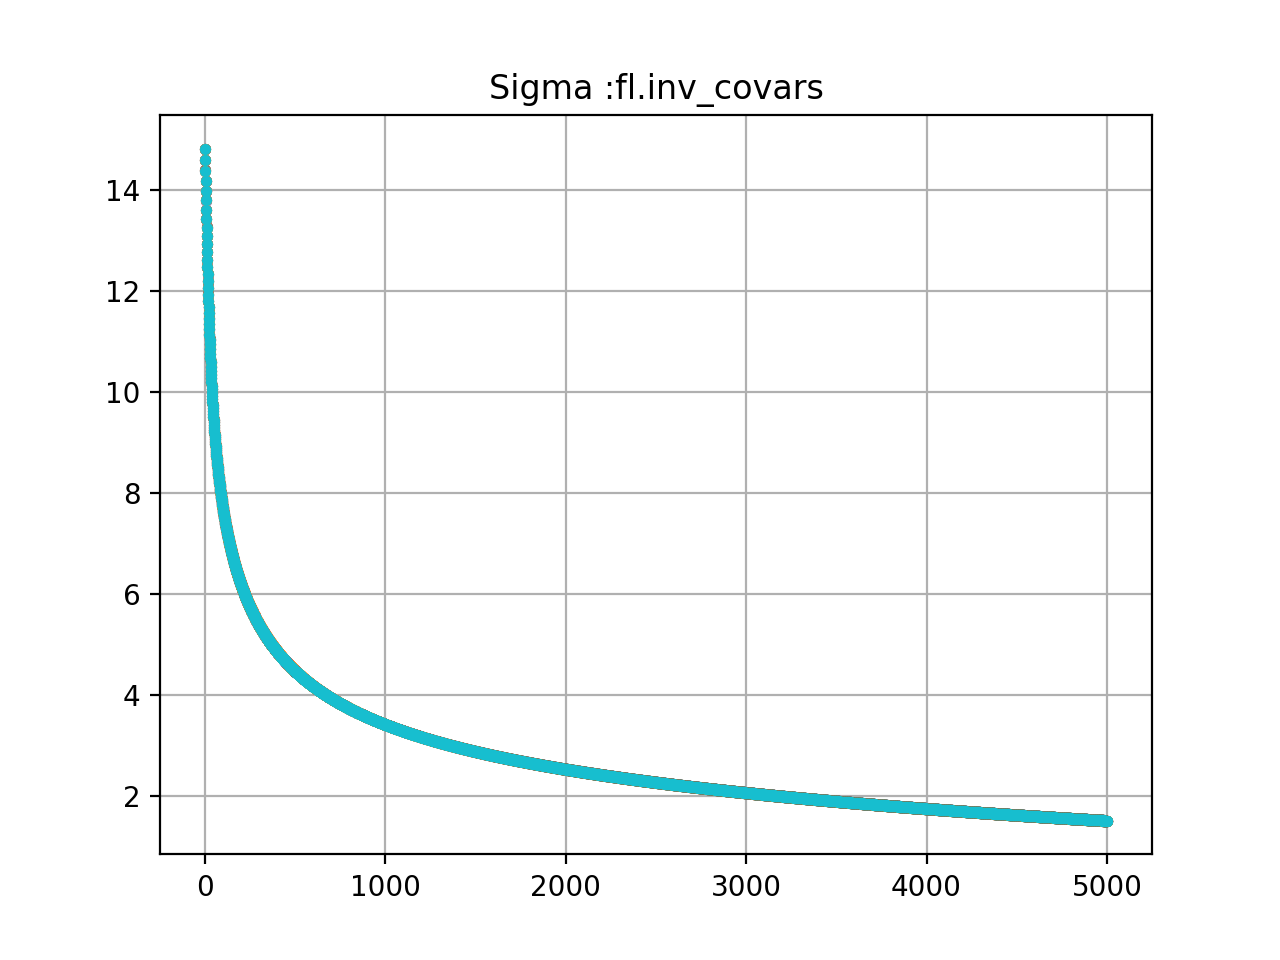

In [106]:
# check that inv_covar went up <=> sigmas went down
fgnl.plot_sigmas_histories(train_res['histories'])

Test set - Average loss: 0.0174, Accuracy: 49773/50000 (100%)
Test set - Average loss: 0.0913, Accuracy: 9762/10000 (98%)


<IPython.core.display.Javascript object>


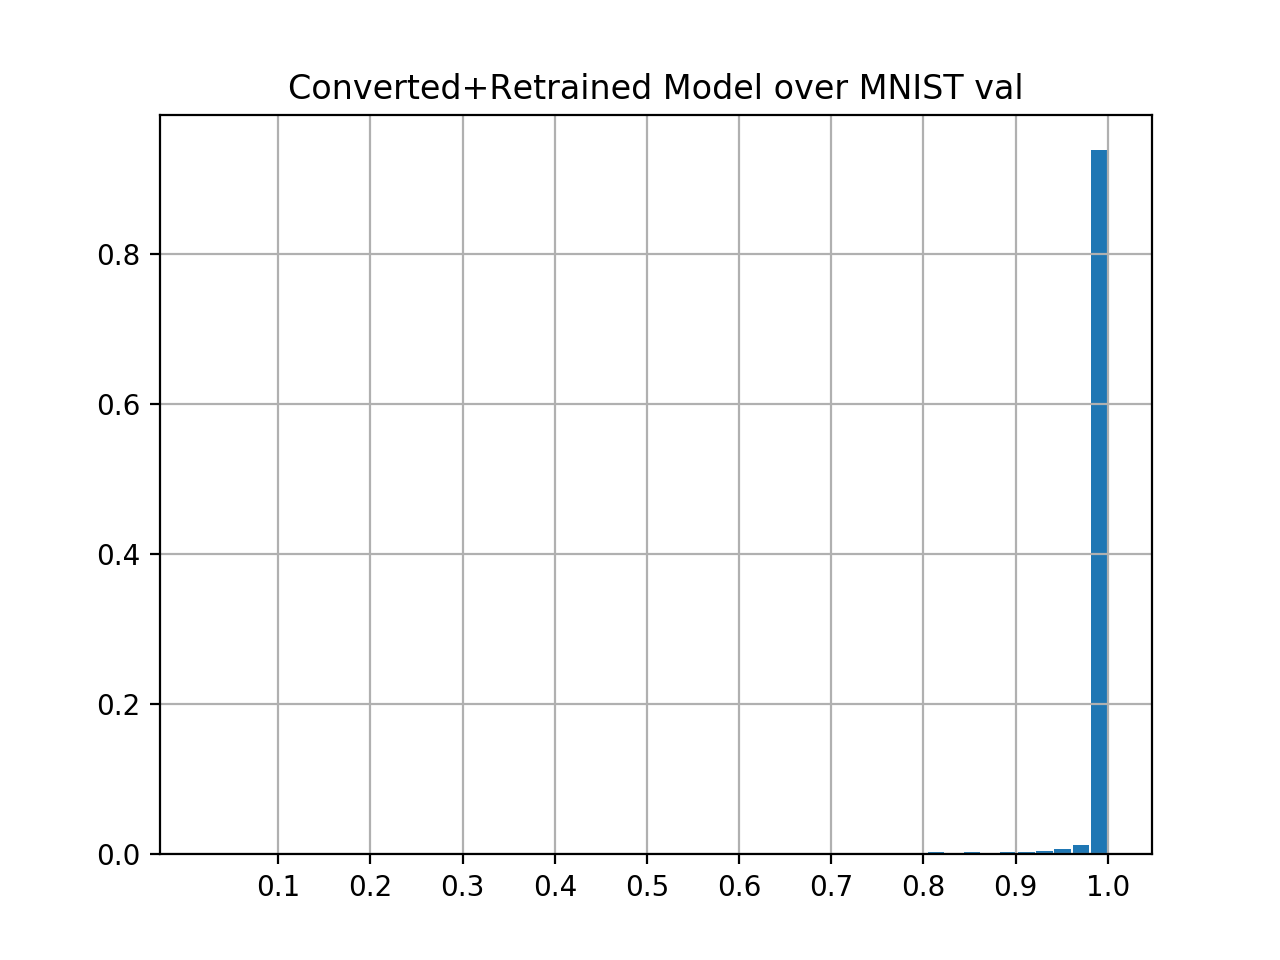

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.10000000000000007334, 0.9999982957555105697), mean=0.98729595074946743127, variance=0.004200422953879016196, skewness=-7.1952652645759828556, kurtosis=61.57585262532665203)

percentage of confident predictions (>=0.5): 0.9967

Sample predictions
index 8247 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index 3681 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 679 prediction [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
index 3959 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index 9705 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [63]:
# check accuracies
test_res = fgnh.test(fgn_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(fgn_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

# check histograms over MNIST
fgnh.plot_pred_histogram(fgn_model, mnist_val_loader, title='Converted+Retrained Model over MNIST val', verbose=True)

In [107]:
# re-attack

In [108]:
attack_params['targeted'] = False

In [109]:
# attack the retrained fgn net
ret_fgn_untargeted_attack_results = fgnl.full_FGSM_attack(fgn_model, dataloader, num_attacks=num_attacks,
                                                      attack_params=attack_params, verbose=verbose)

In [110]:
# extract lists
ret_fgn_untargeted_confidences = ret_fgn_untargeted_attack_results['confidences_list']
ret_fgn_untargeted_steps = ret_fgn_untargeted_attack_results['steps_list']
ret_fgn_untargeted_adv_classes = ret_fgn_untargeted_attack_results['adv_classes_list']
ret_fgn_untargeted_successes = ret_fgn_untargeted_attack_results['successes_list']

# indexes of sucessful attacks any %
ret_fgn_untargeted_successes_indices_any = np.flatnonzero(ret_fgn_untargeted_successes)
# above req
ret_fgn_untargeted_successes_indices_req = [i 
                                        for i,v in enumerate(ret_fgn_untargeted_successes) 
                                        if v and ret_fgn_untargeted_confidences[i]>=attack_params['confidence_req']]

In [111]:
# success rates

print('Success rates with any confidence')
print('Untargeted attack on classic net success rate: {}/{}, {}%'.format(len(classic_untargeted_successes_indices_any),
                                                                         num_attacks,
                                                                         len(classic_untargeted_successes_indices_any)/num_attacks))
print('Untargeted attack on Retrained FGN net success rate: {}/{}, {}%'.format(len(ret_fgn_untargeted_successes_indices_any),
                                                                         num_attacks,
                                                                         len(ret_fgn_untargeted_successes_indices_any)/num_attacks))


Success rates with any confidence
Untargeted attack on classic net success rate: 9972/30000, 0.3324%
Untargeted attack on Retrained FGN net success rate: 0/30000, 0.0%


In [112]:
# success rates above confidence

print('Success rates with confidence >= {}'.format(attack_params['confidence_req']))
print("Untargeted attack on classic net success rate: {}/{}, {}%".format(len(classic_untargeted_successes_indices_req),
                                                                         num_attacks,
                                                                         len(classic_untargeted_successes_indices_req)/num_attacks))
print("Untargeted attack on FGN net success rate: {}/{}, {}%".format(len(ret_fgn_untargeted_successes_indices_req),
                                                                         num_attacks,
                                                                         len(ret_fgn_untargeted_successes_indices_req)/num_attacks))


Success rates with confidence >= 0.5
Untargeted attack on classic net success rate: 9919/30000, 0.33063333333333333%
Untargeted attack on FGN net success rate: 0/30000, 0.0%


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/home/apps/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


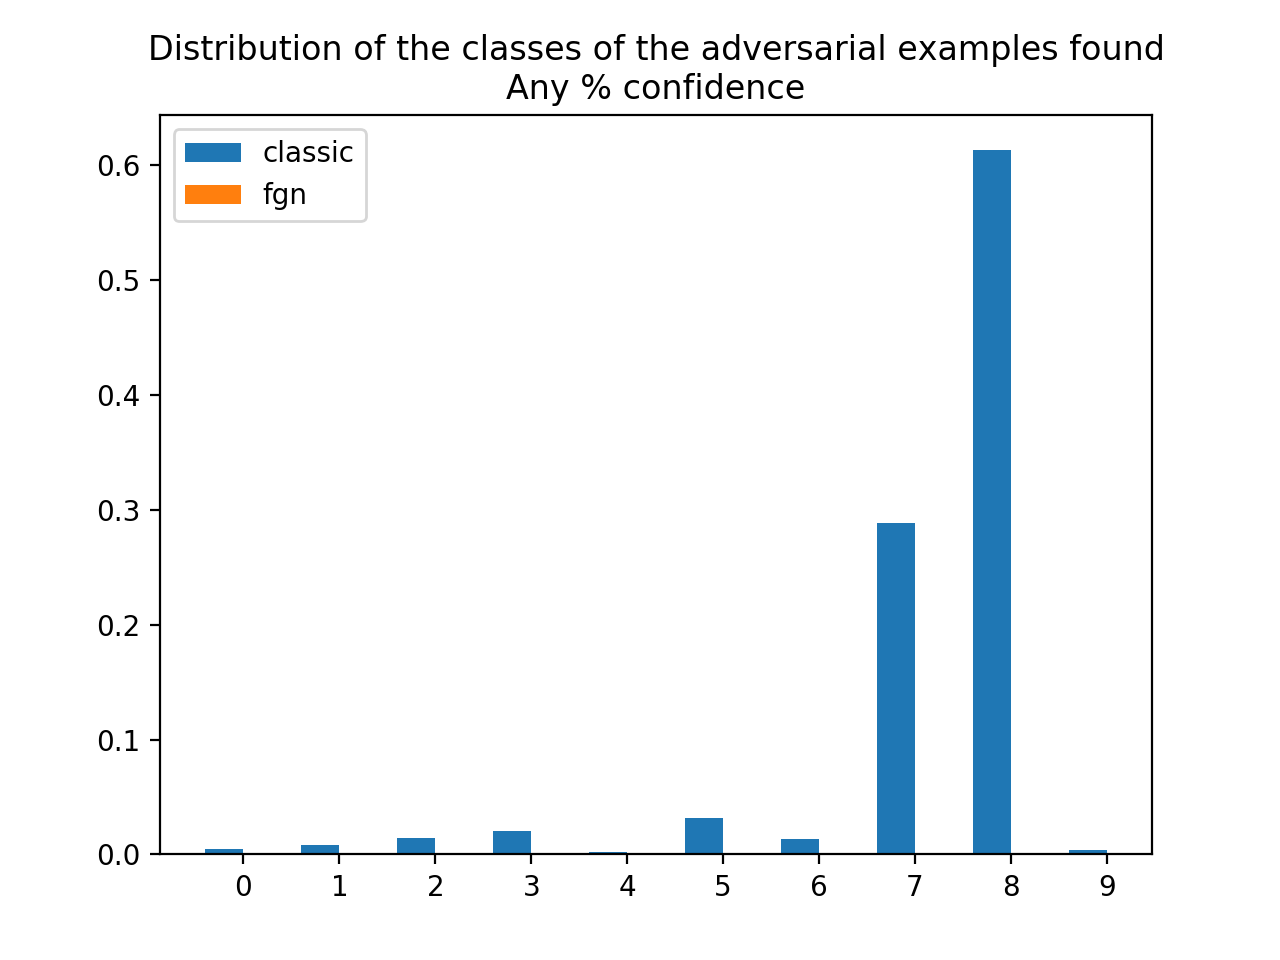

In [113]:
# adversarial class distribution
# plt.hist(classic_untargeted_adv_classes, bins=range(11), align='left', rwidth=0.9, alpha=0.5, label='classic')
# plt.hist(ret_fgn_untargeted_adv_classes, bins=range(11), align='left', rwidth=0.8, alpha=0.5, label='fgn')

# plot 
tp1 = [classic_untargeted_adv_classes[i] for i in classic_untargeted_successes_indices_any]
tp2 = [ret_fgn_untargeted_adv_classes[i] for i in ret_fgn_untargeted_successes_indices_any]

to_plot = [tp1, tp2]
plt.hist(to_plot, bins=range(11), density=True, align='left', rwidth=0.8, alpha=1.0, label=labels)

plt.title("Distribution of the classes of the adversarial examples found\nAny % confidence") 
plt.xticks(range(10))
plt.legend()
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


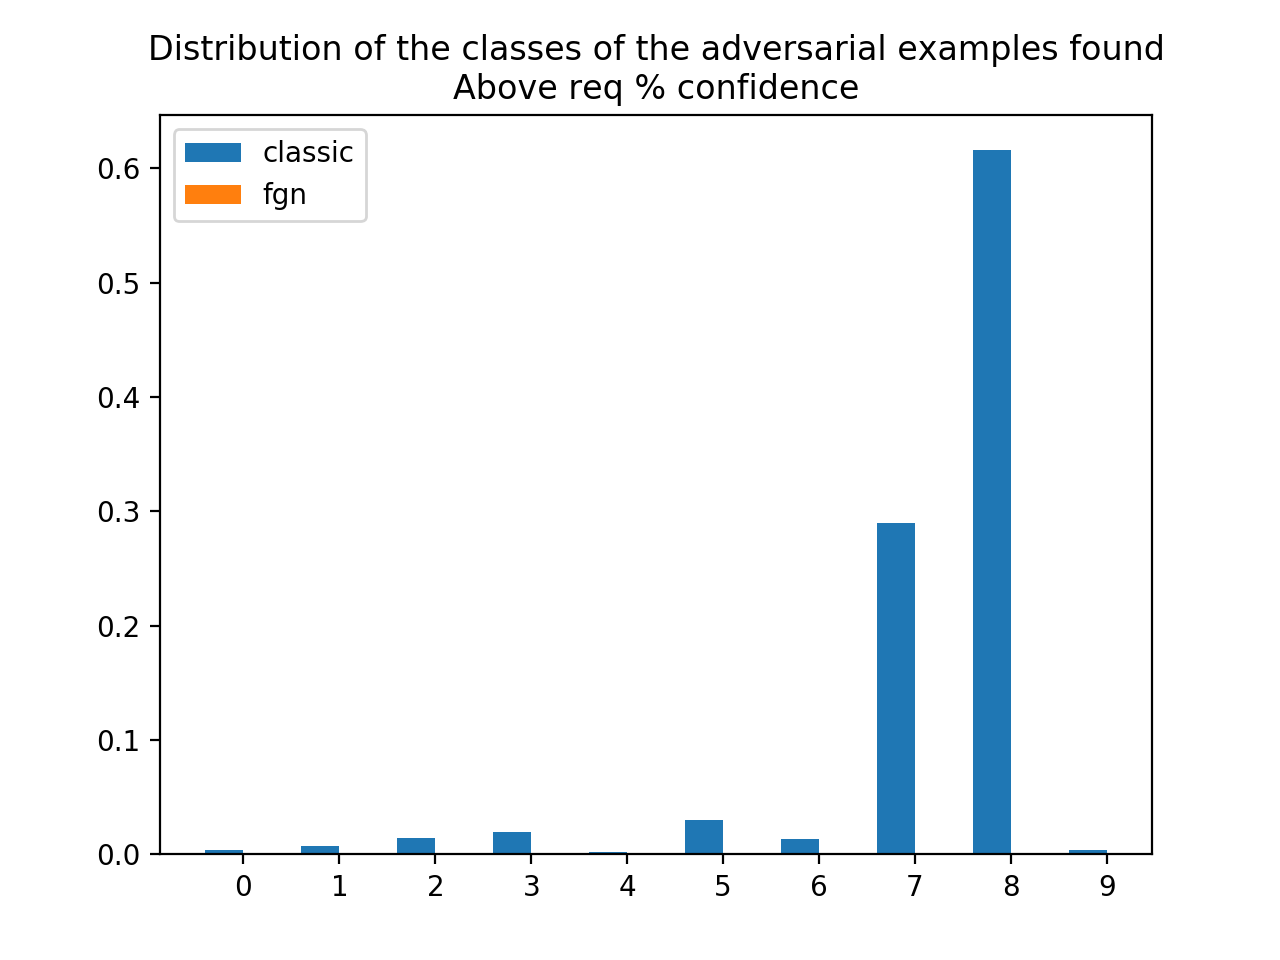

In [114]:
# adversarial class distribution
# plt.hist(classic_untargeted_adv_classes, bins=range(11), align='left', rwidth=0.9, alpha=0.5, label='classic')
# plt.hist(ret_fgn_untargeted_adv_classes, bins=range(11), align='left', rwidth=0.8, alpha=0.5, label='fgn')

# plot 
tp1 = [classic_untargeted_adv_classes[i] for i in classic_untargeted_successes_indices_req]
tp2 = [ret_fgn_untargeted_adv_classes[i] for i in ret_fgn_untargeted_successes_indices_req]

to_plot = [tp1, tp2]
plt.hist(to_plot, bins=range(11), density=True, align='left', rwidth=0.8, alpha=1.0, label=labels)

plt.title("Distribution of the classes of the adversarial examples found\nAbove req % confidence") 
plt.xticks(range(10))
plt.legend()
plt.show()

In [115]:
# plot confidence distribution
# classic_untargeted_successes_confidences = [classic_untargeted_confidences[i] 
#                                             for i in classic_untargeted_successes_indices_any]

# ret_fgn_untargeted_successes_confidences = [ret_fgn_untargeted_confidences[i] 
#                                             for i in ret_fgn_untargeted_successes_indices_any]

print("With -1s")
print("classic confidence stats:\n", stats.describe(classic_untargeted_confidences))
print("fgn confidence stats:\n", stats.describe(ret_fgn_untargeted_confidences))

print()
classic_untargeted_confidences_filtered = list(filter(lambda x:x>=0, classic_untargeted_confidences))
ret_fgn_untargeted_confidences_filtered = list(filter(lambda x:x>=0, ret_fgn_untargeted_confidences))


print("Without -1")
print("classic confidence stats:\n", stats.describe(classic_untargeted_confidences_filtered))
print("fgn confidence stats:\n", stats.describe(ret_fgn_untargeted_confidences_filtered))

plt.hist(classic_untargeted_confidences_filtered, density=True, bins=[x/100 for x in range(101)], alpha=0.66, label='fgn')
plt.hist(ret_fgn_untargeted_confidences_filtered, density=True, bins=[x/100 for x in range(101)], alpha=0.66, label='classic')

# to_plot = [striped_classic_confidence, striped_ret_fgn_confidence]
# plt.hist(to_plot, bins=101, alpha=1.0, label=labels)

plt.title("Distribution of the confidence in the adversarial examples found") 
plt.legend()
plt.show()

With -1s
classic confidence stats:
 DescribeResult(nobs=10000, minmax=(-1.0, 0.9998693466186523), mean=0.882157627248764, variance=0.03276364879535992, skewness=-3.710296338940903, kurtosis=31.087412947954064)
fgn confidence stats:
 DescribeResult(nobs=10000, minmax=(-1.0, -1.0), mean=-1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)

Without -1
classic confidence stats:
 DescribeResult(nobs=9972, minmax=(0.24644288, 0.99986935), mean=0.88744247, variance=0.022879826, skewness=-1.0702728033065796, kurtosis=-0.087868829879584)


ValueError: The input must not be empty.

Classic steps stats:
 DescribeResult(nobs=10000, minmax=(1, 5), mean=1.2023, variance=0.440818791879188, skewness=3.9582347185162017, kurtosis=16.528711759939164)
FGN steps stats:
 DescribeResult(nobs=10000, minmax=(5, 5), mean=5.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


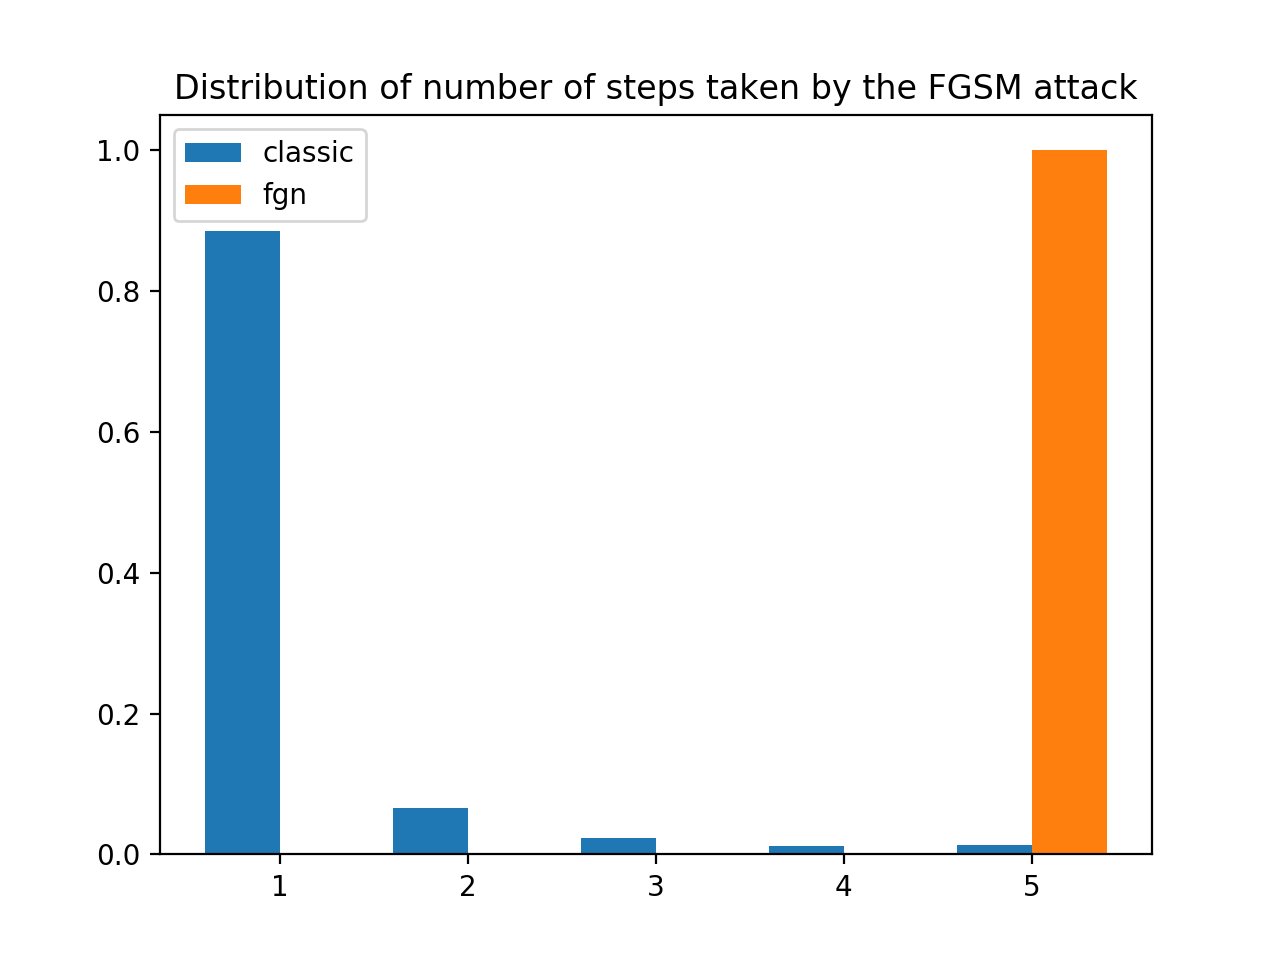

In [116]:
# plot steps distribution 
# steps taken during attacks (successful or not)
print("Classic steps stats:\n", stats.describe(classic_untargeted_steps))
print("FGN steps stats:\n", stats.describe(ret_fgn_untargeted_steps))

# plt.hist(classic_untargeted_steps_dist, bins=range(attack_params['steps']+2), align='left',rwidth =0.9, alpha=0.5, label='classic')
# plt.hist(ret_fgn_untargeted_steps_dist, bins=range(attack_params['steps']+2), align='left',rwidth =0.8, alpha=0.5, label='fgn')

to_plot = [classic_untargeted_steps, ret_fgn_untargeted_steps]
plt.hist(to_plot, density=True, bins=range(attack_params['steps']+2)[1:], align='left', label=labels)

plt.title("Distribution of number of steps taken by the FGSM attack") 
plt.legend()
plt.xticks(range(attack_params['steps']+1)[1:])
plt.show()

In [117]:
# targeted attack

In [118]:
attack_params['targeted'] = True

In [119]:
# attack the fgn net
ret_fgn_targeted_attack_results = fgnl.full_FGSM_attack(fgn_model, dataloader, num_attacks=num_attacks,
                                                      attack_params=attack_params, verbose=verbose)

In [120]:
# extract lists
ret_fgn_targeted_confidences = ret_fgn_targeted_attack_results['confidences_list']
ret_fgn_targeted_steps = ret_fgn_targeted_attack_results['steps_list']
ret_fgn_targeted_adv_classes = ret_fgn_targeted_attack_results['adv_classes_list']
ret_fgn_targeted_successes = ret_fgn_targeted_attack_results['successes_list']

# indexes of sucessful attacks any %
ret_fgn_targeted_successes_indices_any = np.flatnonzero(ret_fgn_targeted_successes)
# above req
ret_fgn_targeted_successes_indices_req = [i
                                            for i,v in enumerate(ret_fgn_targeted_successes)
                                            if v and ret_fgn_targeted_confidences[i]>=attack_params['confidence_req']]

In [121]:
# success rates

print('Success rates with any confidence')
print('targeted attack on classic net success rate: {}/{}, {}%'.format(len(classic_targeted_successes_indices_any),
                                                                         num_attacks,
                                                                         len(classic_targeted_successes_indices_any)/num_attacks))
print('targeted attack on Retrained FGN net success rate: {}/{}, {}%'.format(len(ret_fgn_targeted_successes_indices_any),
                                                                         num_attacks,
                                                                         len(ret_fgn_targeted_successes_indices_any)/num_attacks))


Success rates with any confidence
targeted attack on classic net success rate: 3678/30000, 0.1226%
targeted attack on Retrained FGN net success rate: 958/30000, 0.031933333333333334%


In [122]:
# success rates above confidence

print('Success rates with confidence >= {}'.format(attack_params['confidence_req']))
print("targeted attack on classic net success rate: {}/{}, {}%".format(len(classic_targeted_successes_indices_req),
                                                                         num_attacks,
                                                                         len(classic_targeted_successes_indices_req)/num_attacks))
print("targeted attack on FGN net success rate: {}/{}, {}%".format(len(ret_fgn_targeted_successes_indices_req),
                                                                         num_attacks,
                                                                         len(ret_fgn_targeted_successes_indices_req)/num_attacks))


Success rates with confidence >= 0.5
targeted attack on classic net success rate: 3204/30000, 0.1068%
targeted attack on FGN net success rate: 0/30000, 0.0%


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


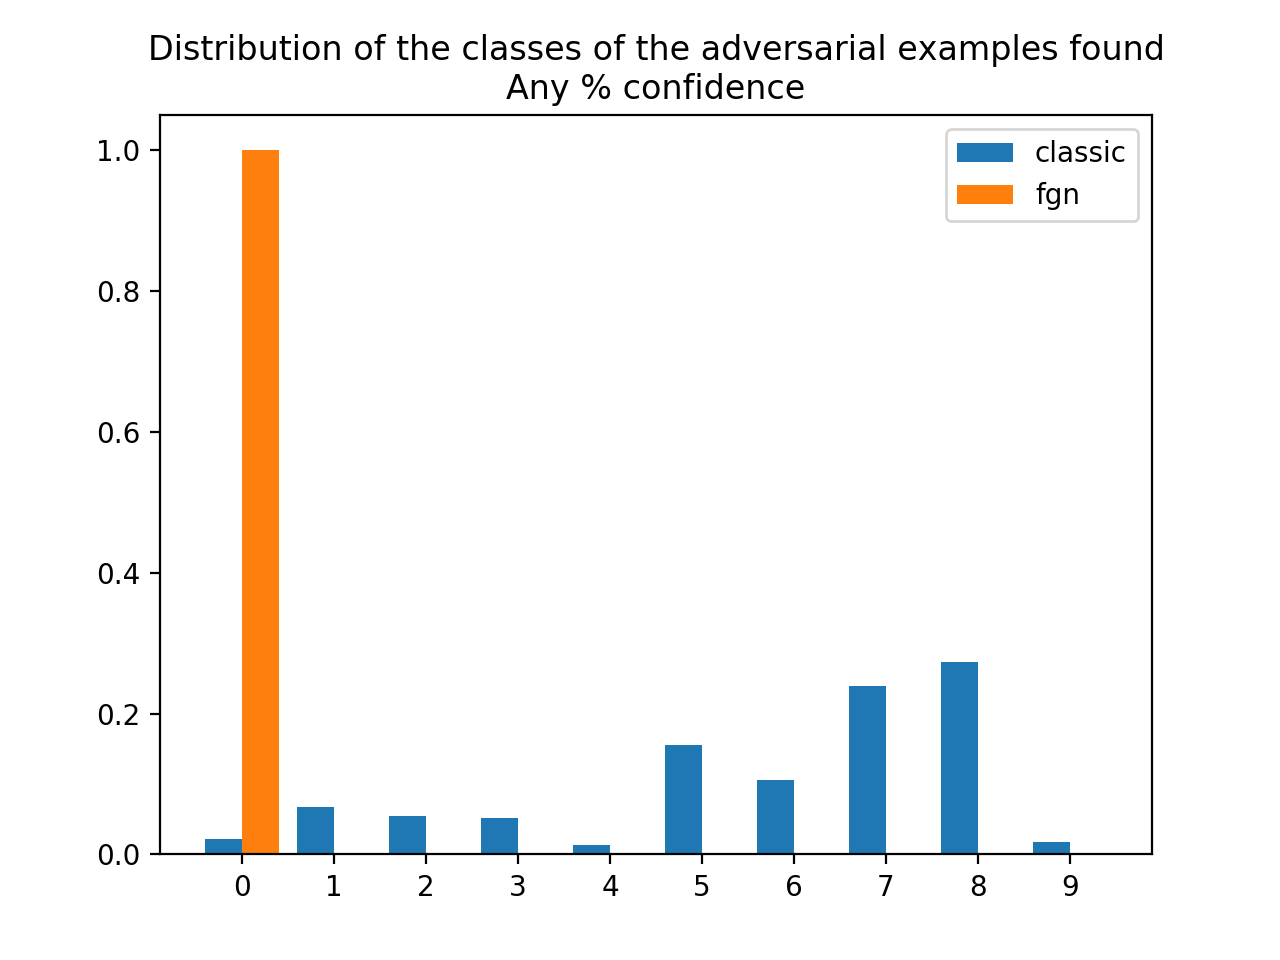

In [123]:
# adversarial class distribution
# plt.hist(classic_targeted_adv_classes, bins=range(11), align='left', rwidth=0.9, alpha=0.5, label='classic')
# plt.hist(ret_fgn_targeted_adv_classes, bins=range(11), align='left', rwidth=0.8, alpha=0.5, label='fgn')

# plot 
tp1 = [classic_targeted_adv_classes[i] for i in classic_targeted_successes_indices_any]
tp2 = [ret_fgn_targeted_adv_classes[i] for i in ret_fgn_targeted_successes_indices_any]

to_plot = [tp1, tp2]
plt.hist(to_plot, bins=range(11), density=True, align='left', rwidth=0.8, alpha=1.0, label=labels)

plt.title("Distribution of the classes of the adversarial examples found\nAny % confidence") 
plt.xticks(range(10))
plt.legend()
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


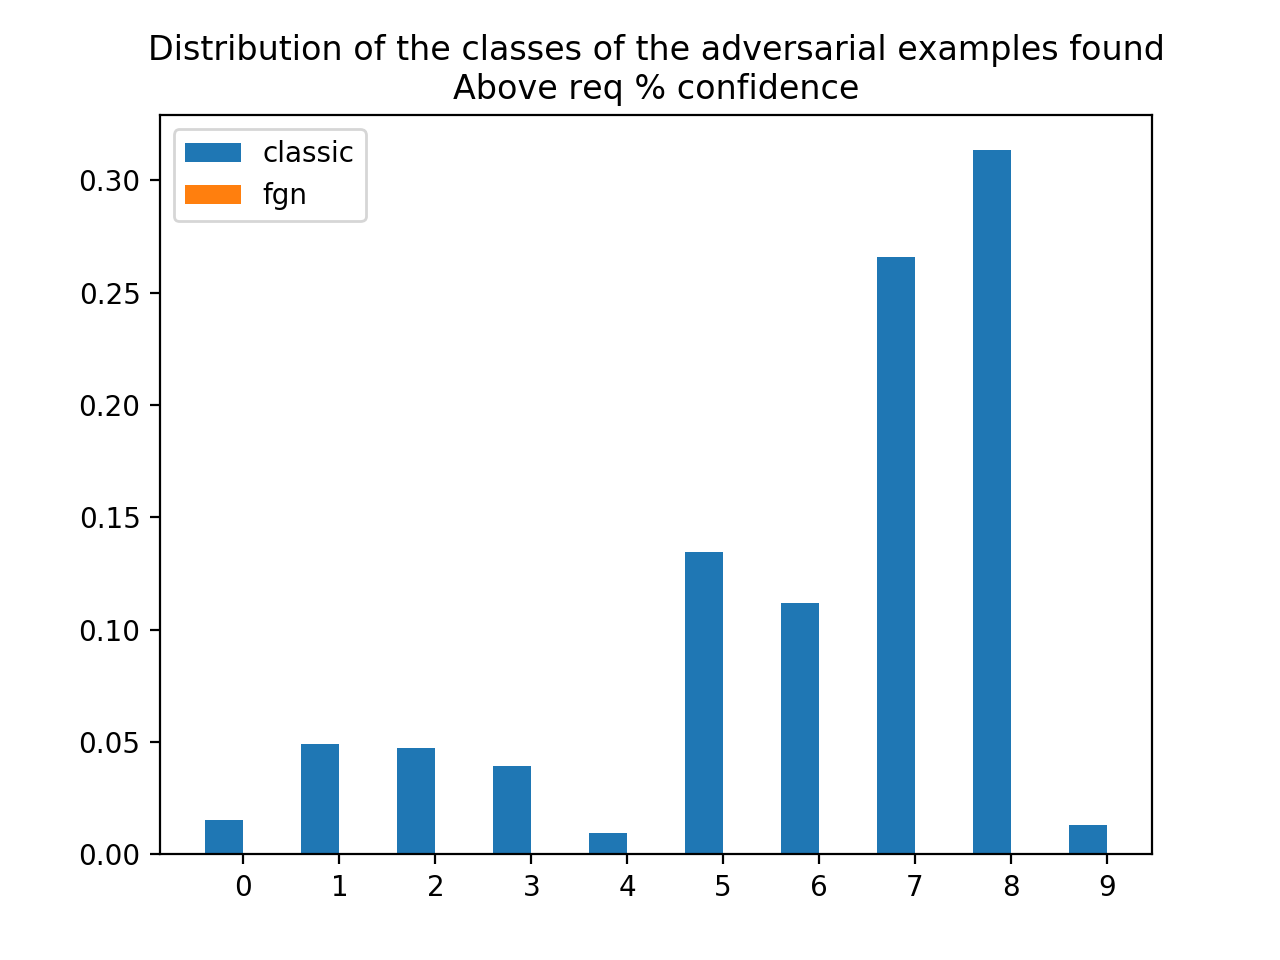

In [124]:
# adversarial class distribution
# plt.hist(classic_targeted_adv_classes, bins=range(11), align='left', rwidth=0.9, alpha=0.5, label='classic')
# plt.hist(ret_fgn_targeted_adv_classes, bins=range(11), align='left', rwidth=0.8, alpha=0.5, label='fgn')

# plot 
tp1 = [classic_targeted_adv_classes[i] for i in classic_targeted_successes_indices_req]
tp2 = [ret_fgn_targeted_adv_classes[i] for i in ret_fgn_targeted_successes_indices_req]

to_plot = [tp1, tp2]
plt.hist(to_plot, bins=range(11), density=True, align='left', rwidth=0.8, alpha=1.0, label=labels)

plt.title("Distribution of the classes of the adversarial examples found\nAbove req % confidence") 
plt.xticks(range(10))
plt.legend()
plt.show()

With -1s
classic confidence stats:
 DescribeResult(nobs=10000, minmax=(-1.0, 0.9998080134391785), mean=-0.34803597492873667, variance=0.7464000099350818, skewness=0.6104604246221051, kurtosis=-1.5516769037510656)
fgn confidence stats:
 DescribeResult(nobs=10000, minmax=(-1.0, 0.10000000149011612), mean=-0.8946199998572468, variance=0.10482353823779397, skewness=2.7467004518564817, kurtosis=5.544363372228606)

Without -1
classic confidence stats:
 DescribeResult(nobs=3678, minmax=(0.23711872, 0.999808), mean=0.7726047, variance=0.042719435, skewness=-0.5042827725410461, kurtosis=-0.8997459129710839)
fgn confidence stats:
 DescribeResult(nobs=958, minmax=(0.1, 0.1), mean=0.10000002, variance=2.2227664e-16, skewness=-1.0, kurtosis=-2.0)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


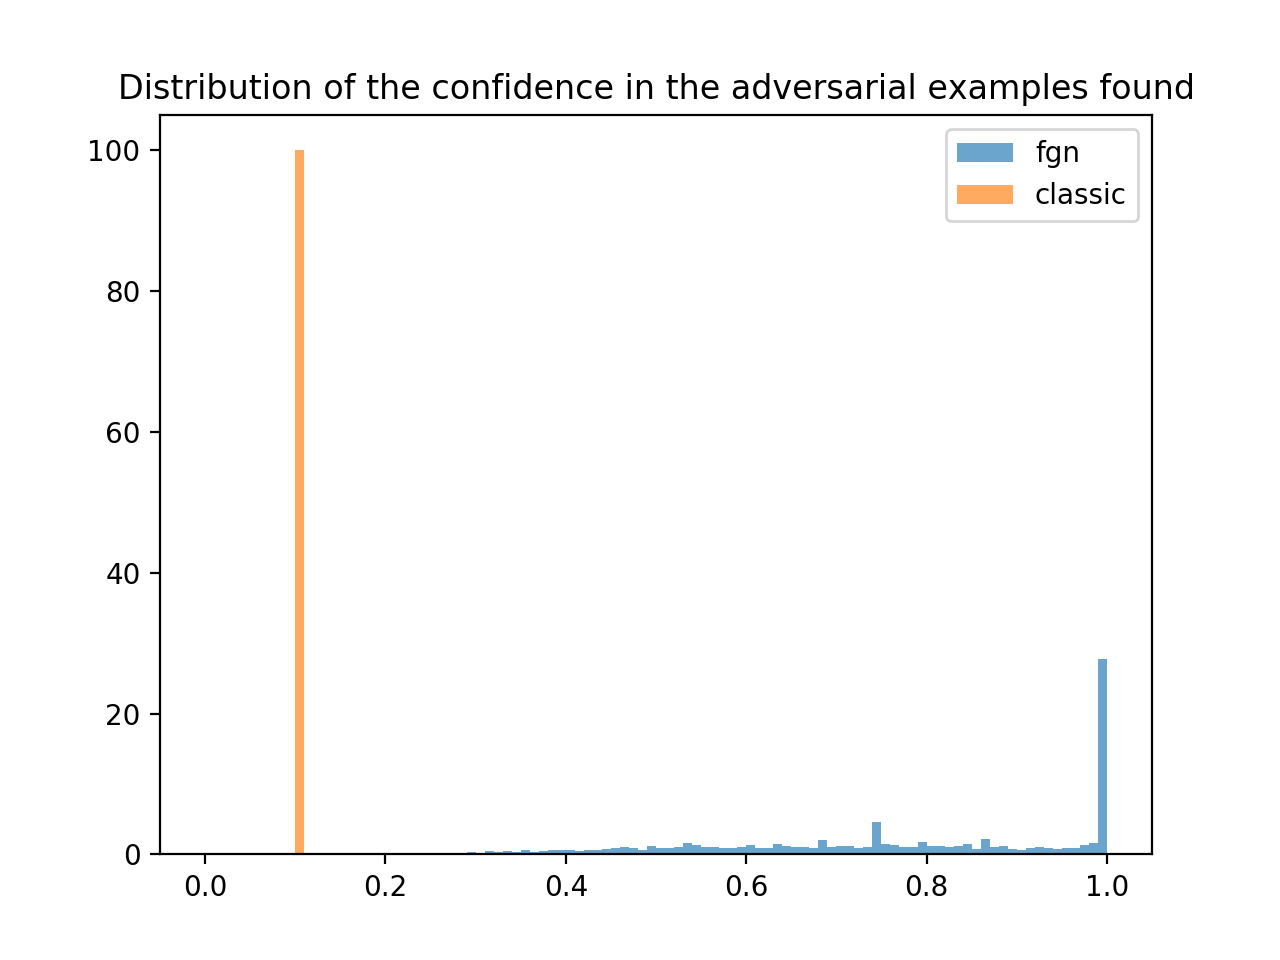

In [125]:
# plot confidence distribution
# classic_targeted_successes_confidences = [classic_targeted_confidences[i] 
#                                             for i in classic_targeted_successes_indices_any]

# ret_fgn_targeted_successes_confidences = [ret_fgn_targeted_confidences[i] 
#                                             for i in ret_fgn_targeted_successes_indices_any]

print("With -1s")
print("classic confidence stats:\n", stats.describe(classic_targeted_confidences))
print("fgn confidence stats:\n", stats.describe(ret_fgn_targeted_confidences))

print()
classic_targeted_confidences_filtered = list(filter(lambda x:x>=0, classic_targeted_confidences))
ret_fgn_targeted_confidences_filtered = list(filter(lambda x:x>=0, ret_fgn_targeted_confidences))


print("Without -1")
print("classic confidence stats:\n", stats.describe(classic_targeted_confidences_filtered))
print("fgn confidence stats:\n", stats.describe(ret_fgn_targeted_confidences_filtered))

plt.hist(classic_targeted_confidences_filtered, density=True, bins=[x/100 for x in range(101)], alpha=0.66, label='fgn')
plt.hist(ret_fgn_targeted_confidences_filtered, density=True, bins=[x/100 for x in range(101)], alpha=0.66, label='classic')

# to_plot = [striped_classic_confidence, striped_ret_fgn_confidence]
# plt.hist(to_plot, bins=101, alpha=1.0, label=labels)

plt.title("Distribution of the confidence in the adversarial examples found") 
plt.legend()
plt.show()

Classic steps stats:
 DescribeResult(nobs=10000, minmax=(1, 5), mean=4.1061, variance=2.333876177617762, skewness=-1.3035562745370064, kurtosis=-0.07857089700849151)
FGN steps stats:
 DescribeResult(nobs=10000, minmax=(5, 5), mean=5.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


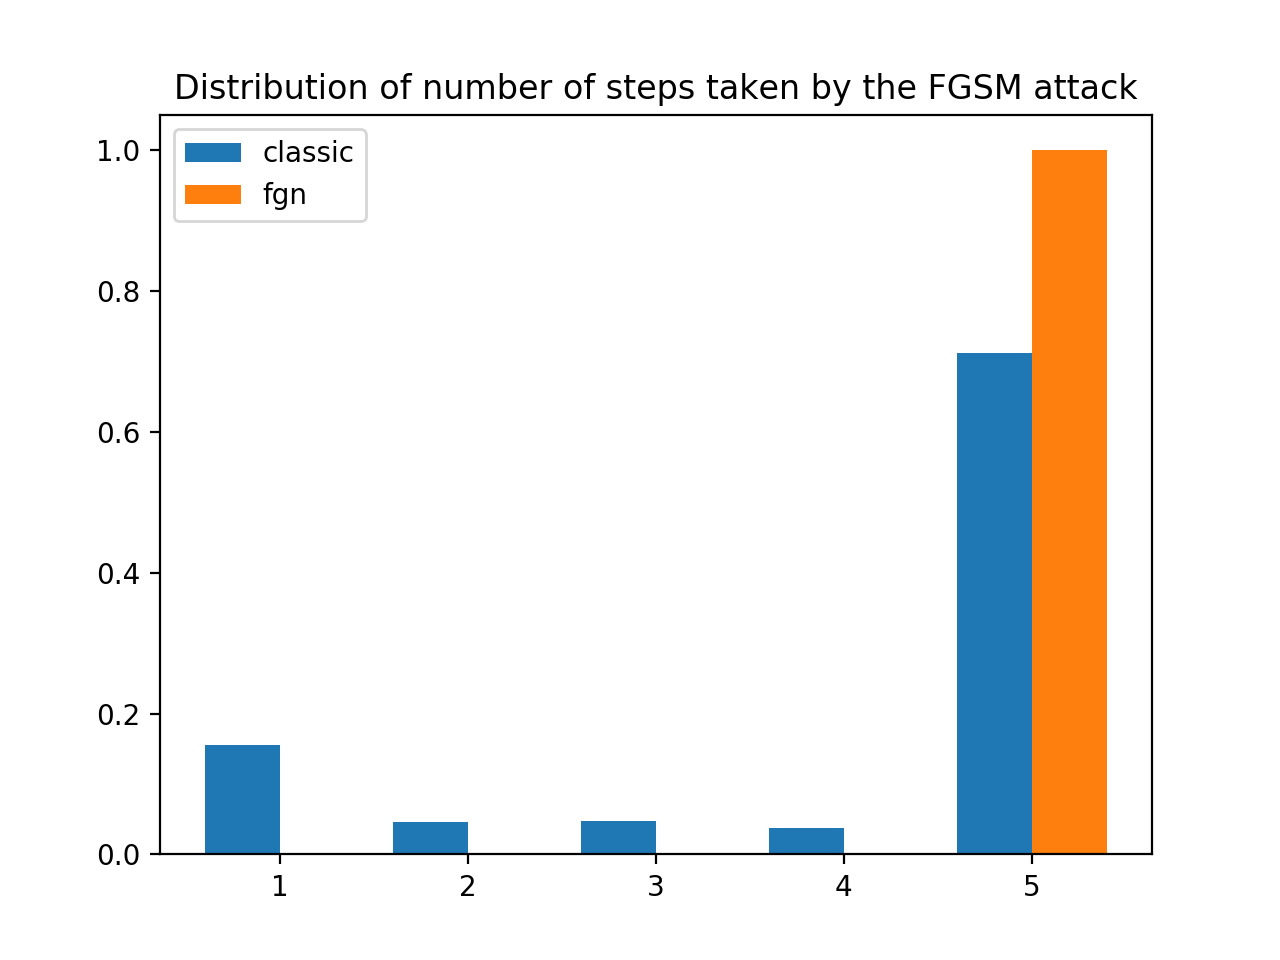

In [126]:
# plot steps distribution 
# steps taken during attacks (successful or not)
print("Classic steps stats:\n", stats.describe(classic_targeted_steps))
print("FGN steps stats:\n", stats.describe(ret_fgn_targeted_steps))

# plt.hist(classic_targeted_steps_dist, bins=range(attack_params['steps']+2), align='left',rwidth =0.9, alpha=0.5, label='classic')
# plt.hist(ret_fgn_targeted_steps_dist, bins=range(attack_params['steps']+2), align='left',rwidth =0.8, alpha=0.5, label='fgn')

to_plot = [classic_targeted_steps, ret_fgn_targeted_steps]
plt.hist(to_plot, density=True, bins=range(attack_params['steps']+2)[1:], align='left', label=labels)

plt.title("Distribution of number of steps taken by the FGSM attack") 
plt.legend()
plt.xticks(range(attack_params['steps']+1)[1:])
plt.show()